# Machine / Deep Learning email classification and analysis

This project aims to develop a system for the analysis and classification of emails received, using different Python libraries for machine learning (scikit-learn, Tensorflow) and Natural Language Processing (NLTK, Gensim, Spacy). Specifically, a machine learning classifier will be trained to identify SPAM emails and, subsequently, some in-depth content analyses will be performed, including:
- identification of main topics among the emails classified as SPAM;
- calculation of semantic distances among topics to evaluate the content heterogeneity of SPAM emails;
- extraction of organizations mentioned in NON-SPAM emails.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from collections import Counter
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.layers import TextVectorization
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, precision_recall_curve,
    roc_curve, average_precision_score
)
from tensorflow.keras.backend import clear_session
from tensorflow.keras import layers, models
import keras
import gensim.corpora as corpora
from gensim.models import LdaMulticore, doc2vec
from scipy.spatial.distance import cosine

In [2]:
# Setting some parameters for matplotlib figures
plt.rcParams["figure.dpi"] = 240
sns.set_theme()

In [ ]:
# Load the original dataset
df_path = "spam_dataset.csv"
df = pd.read_csv(df_path)

## 1) Exploratory data analysis

First, an exploration of the dataset is peformed, to better understand the main characteristics of the text data.

### Dataset overview

In [4]:
# Dataset size and first 5 rows
print(f"Dataset size: {df.shape[0]} rows and {df.shape[1]} columns")
df.head()

Dataset size: 5171 rows and 4 columns


,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\nthis deal is to ...,0


In [5]:
# General information on the dataset
print("Dataset info:")
df.info()

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [6]:
# Count of null values per column
print("Null values:")
print(df.isnull().sum())

Null values:
Unnamed: 0    0
label         0
text          0
label_num     0
dtype: int64


None of the variables has null values, so no handling is required to clean the dataset in this regard.

### Distribution of classes

Here the distribution of the 'label' variable (ham/spam) is analysed, to identify possible imbalances in samples (email classes).

In [7]:
ham_spam_count = df['label'].value_counts()
ham_spam_pct = df['label'].value_counts(normalize=True) * 100

print("Distribution of email classes (ham/spam):")
print(f"  0 (Ham): {ham_spam_count.iloc[0]} comments ({ham_spam_pct.iloc[0]:.2f}%)")
print(f"  1 (Spam): {ham_spam_count.iloc[1]} comments ({ham_spam_pct.iloc[1]:.2f}%)")

Distribution of email classes (ham/spam):
  0 (Ham): 3672 comments (71.01%)
  1 (Spam): 1499 comments (28.99%)


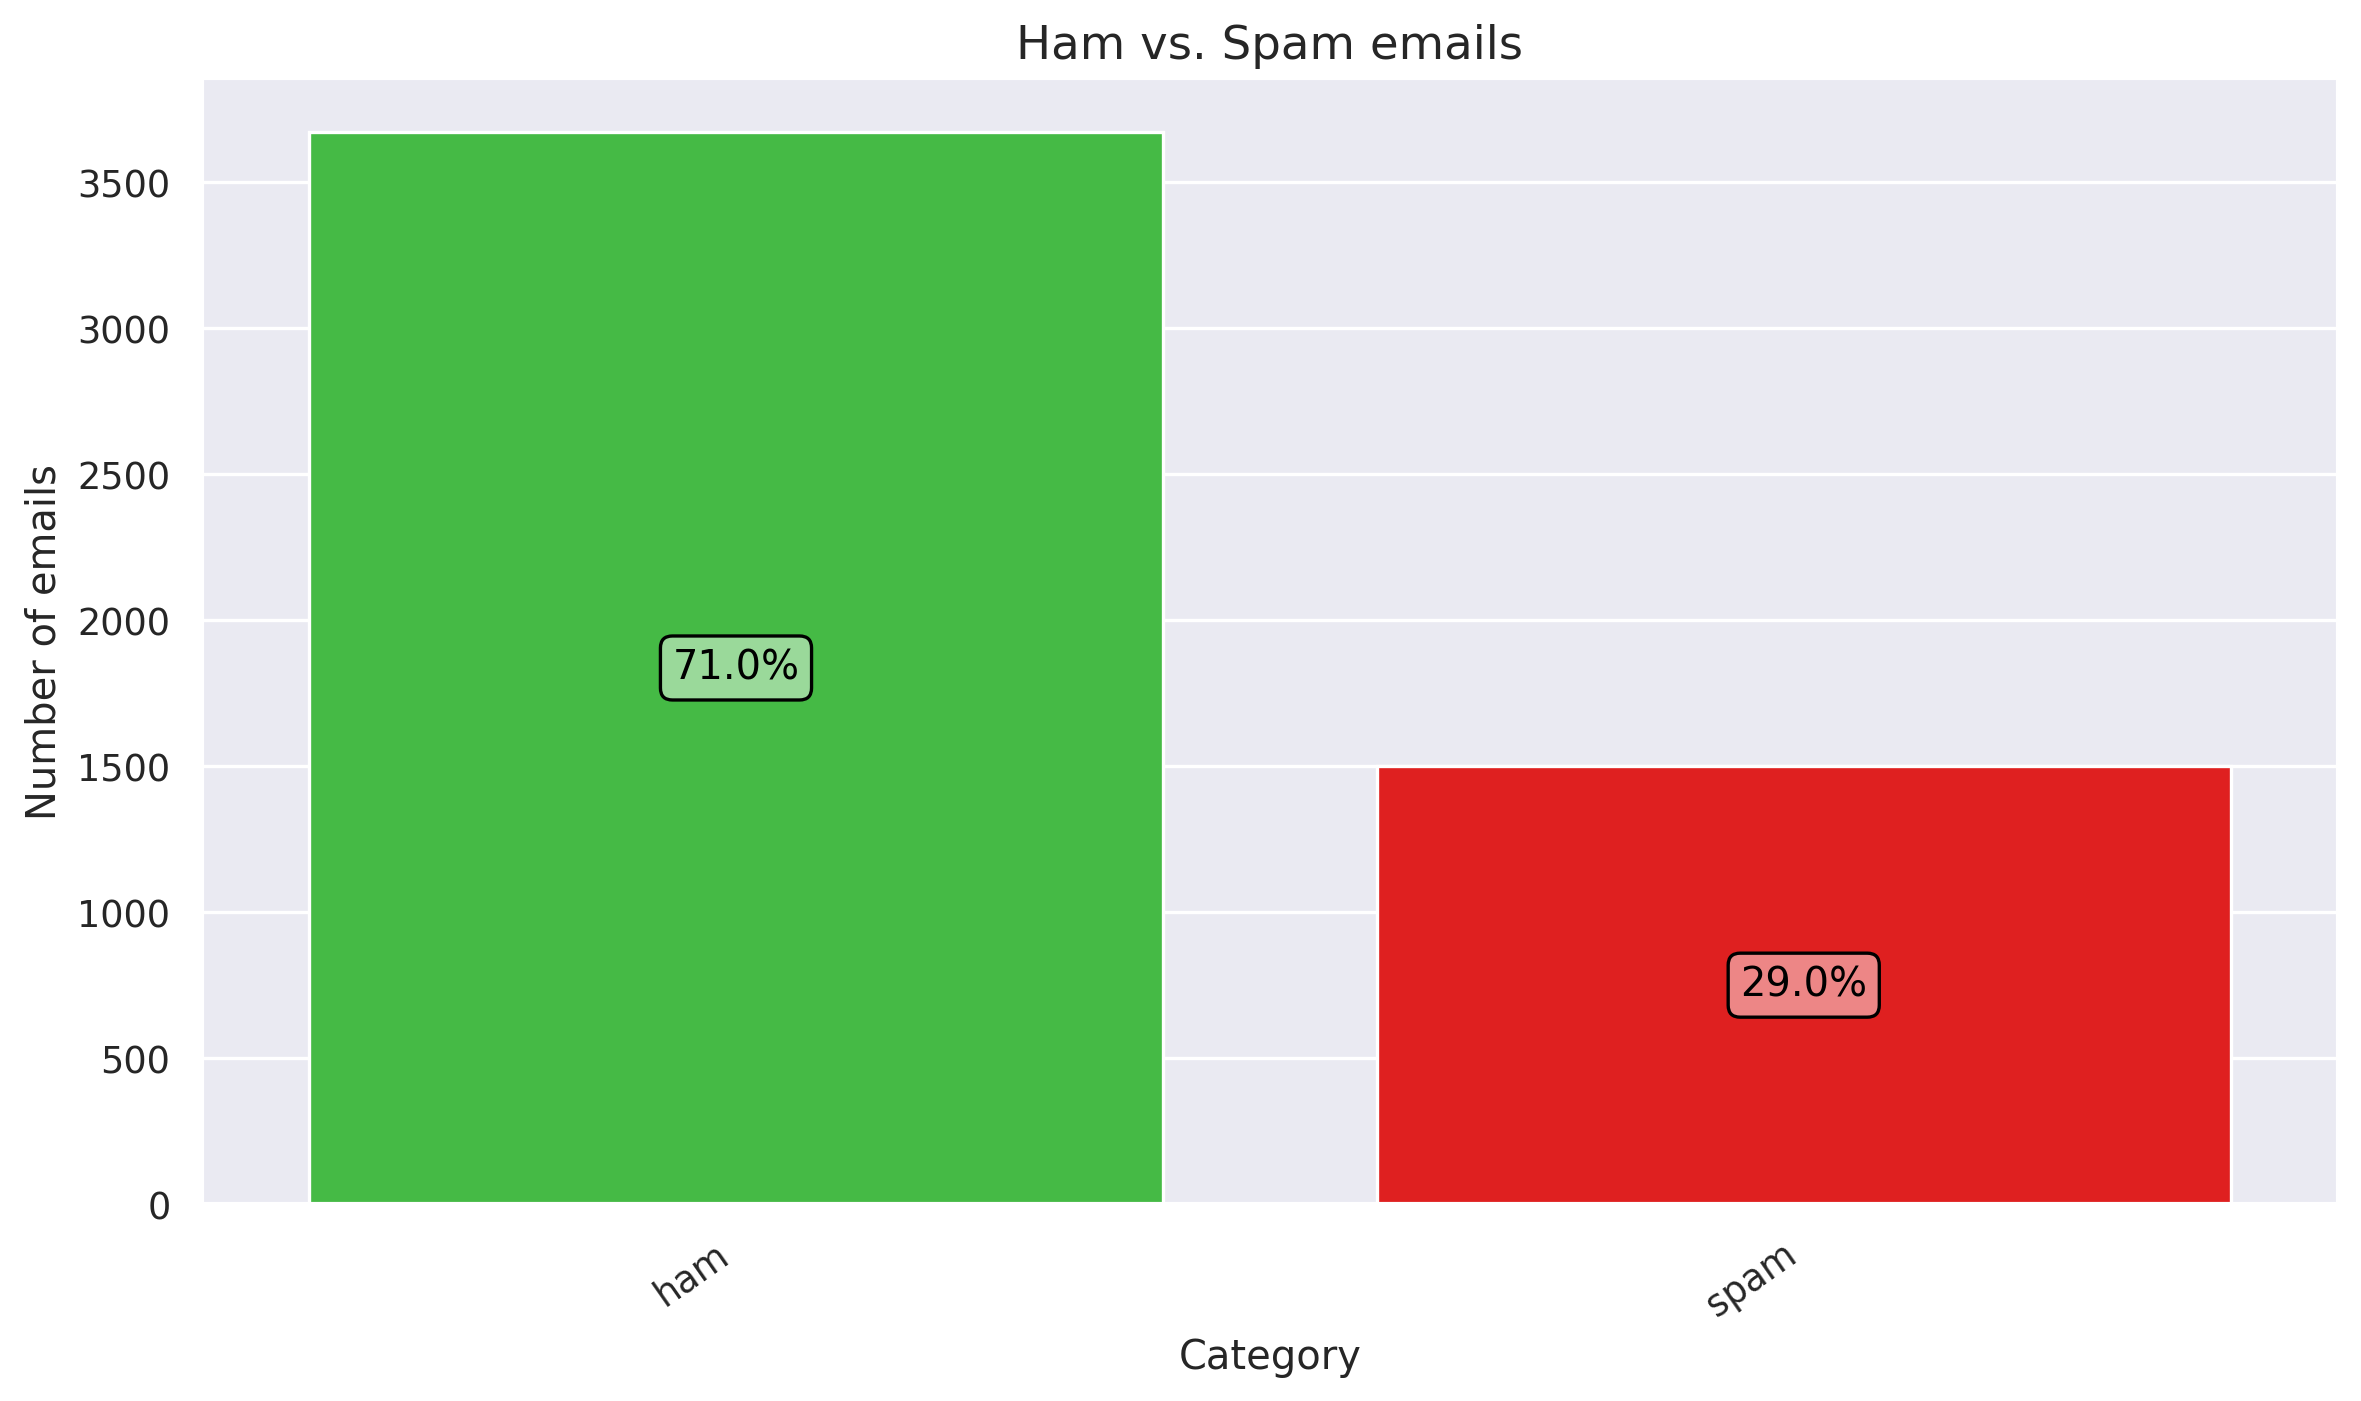

In [8]:
# Bar plot of email classes
plt.figure(figsize=(10,6))
sns.barplot(x=ham_spam_count.index, y=ham_spam_count.values, hue=ham_spam_count.index, palette=['limegreen', 'red'])
plt.xlabel("Category")
plt.ylabel("Number of emails")
plt.title("Ham vs. Spam emails", fontsize=14)
plt.xticks(rotation=35, ha='right')

for i, count in enumerate(ham_spam_count):
    plt.annotate(f"{ham_spam_pct.iloc[i]:.1f}%",
                 xy=(i, ham_spam_count.iloc[i]/2),
                 ha='center', va='center',
                 fontsize=12, color='black',
                 bbox = dict(boxstyle="round", ec='black', fc="#ffffff75"))

plt.tight_layout()
plt.show()

It can be observed that the distribution of the "ham" vs "spam" samples is quite inbalanced, since 71% of emails are associated with the "ham" class.

### Length analysis

Here, the distribution of email length (considering the number of words) is explored, first overall and then by class.

In [9]:
# Apply a simple tokenisation on whitespace and punctuation
nltk.download('punkt')
nltk.download('punkt_tab')
tokens_col = df["text"].apply(nltk.word_tokenize)

# Compute number of words per email
df['word_count'] = tokens_col.apply(len)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [10]:
df[['text','word_count']].head()

,text,word_count
0,Subject: enron methanol ; meter # : 988291\nth...,68
1,"Subject: hpl nom for january 9 , 2001\n( see a...",24
2,"Subject: neon retreat\nho ho ho , we ' re arou...",551
3,"Subject: photoshop , windows , office . cheap ...",49
4,Subject: re : indian springs\nthis deal is to ...,71


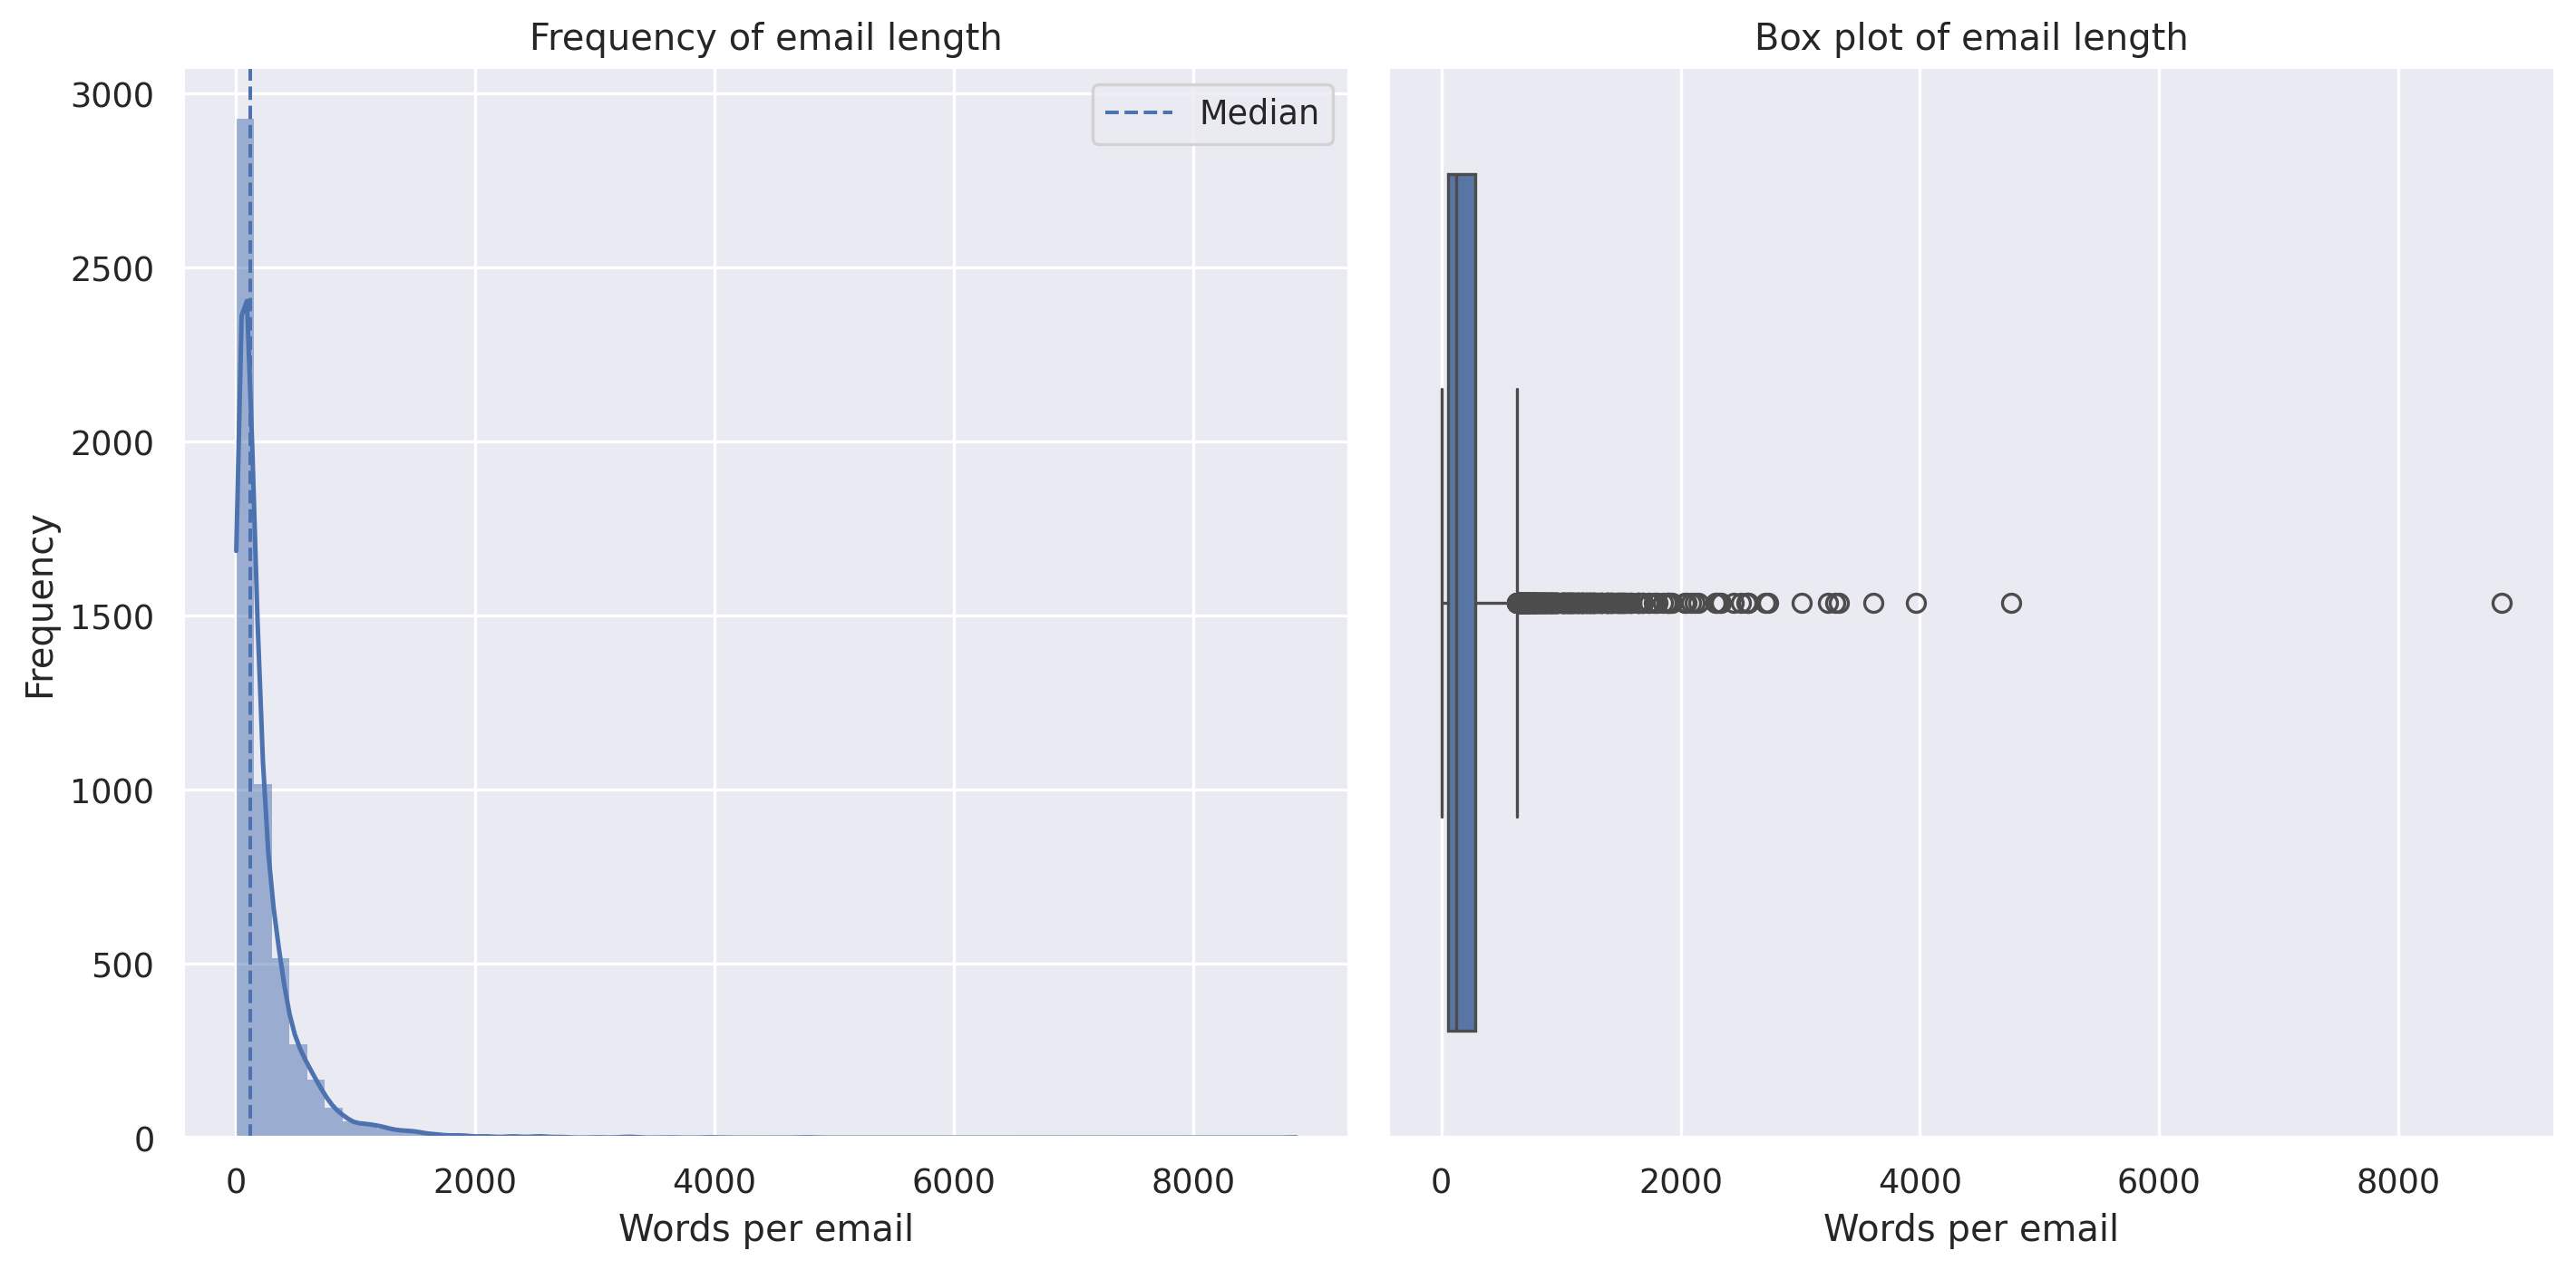

In [11]:
# Overall length distribution

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
sns.histplot(df['word_count'], bins=60, kde=True, edgecolor='none')
plt.axvline(df['word_count'].median(), ls='--', lw=1.2, label='Median')
plt.xlabel("Words per email")
plt.ylabel("Frequency")
plt.title("Frequency of email length")
plt.legend()

plt.subplot(1, 2, 2)
bp = sns.boxplot(df['word_count'], orient="y")
plt.xlabel("Words per email")
plt.title("Box plot of email length")

plt.tight_layout()
plt.show()

In [12]:
# Calculate lenght distribution statistics of emails (overall)
df_len_stats = df['word_count'].describe(percentiles=[.50, .75, .90, .95, .99])
df_len_stats

,word_count
count,5171.000000
mean,229.181009
std,336.487397
min,2.000000
50%,122.000000
75%,283.500000
90%,548.000000
95%,766.000000
99%,1504.600000
max,8863.000000


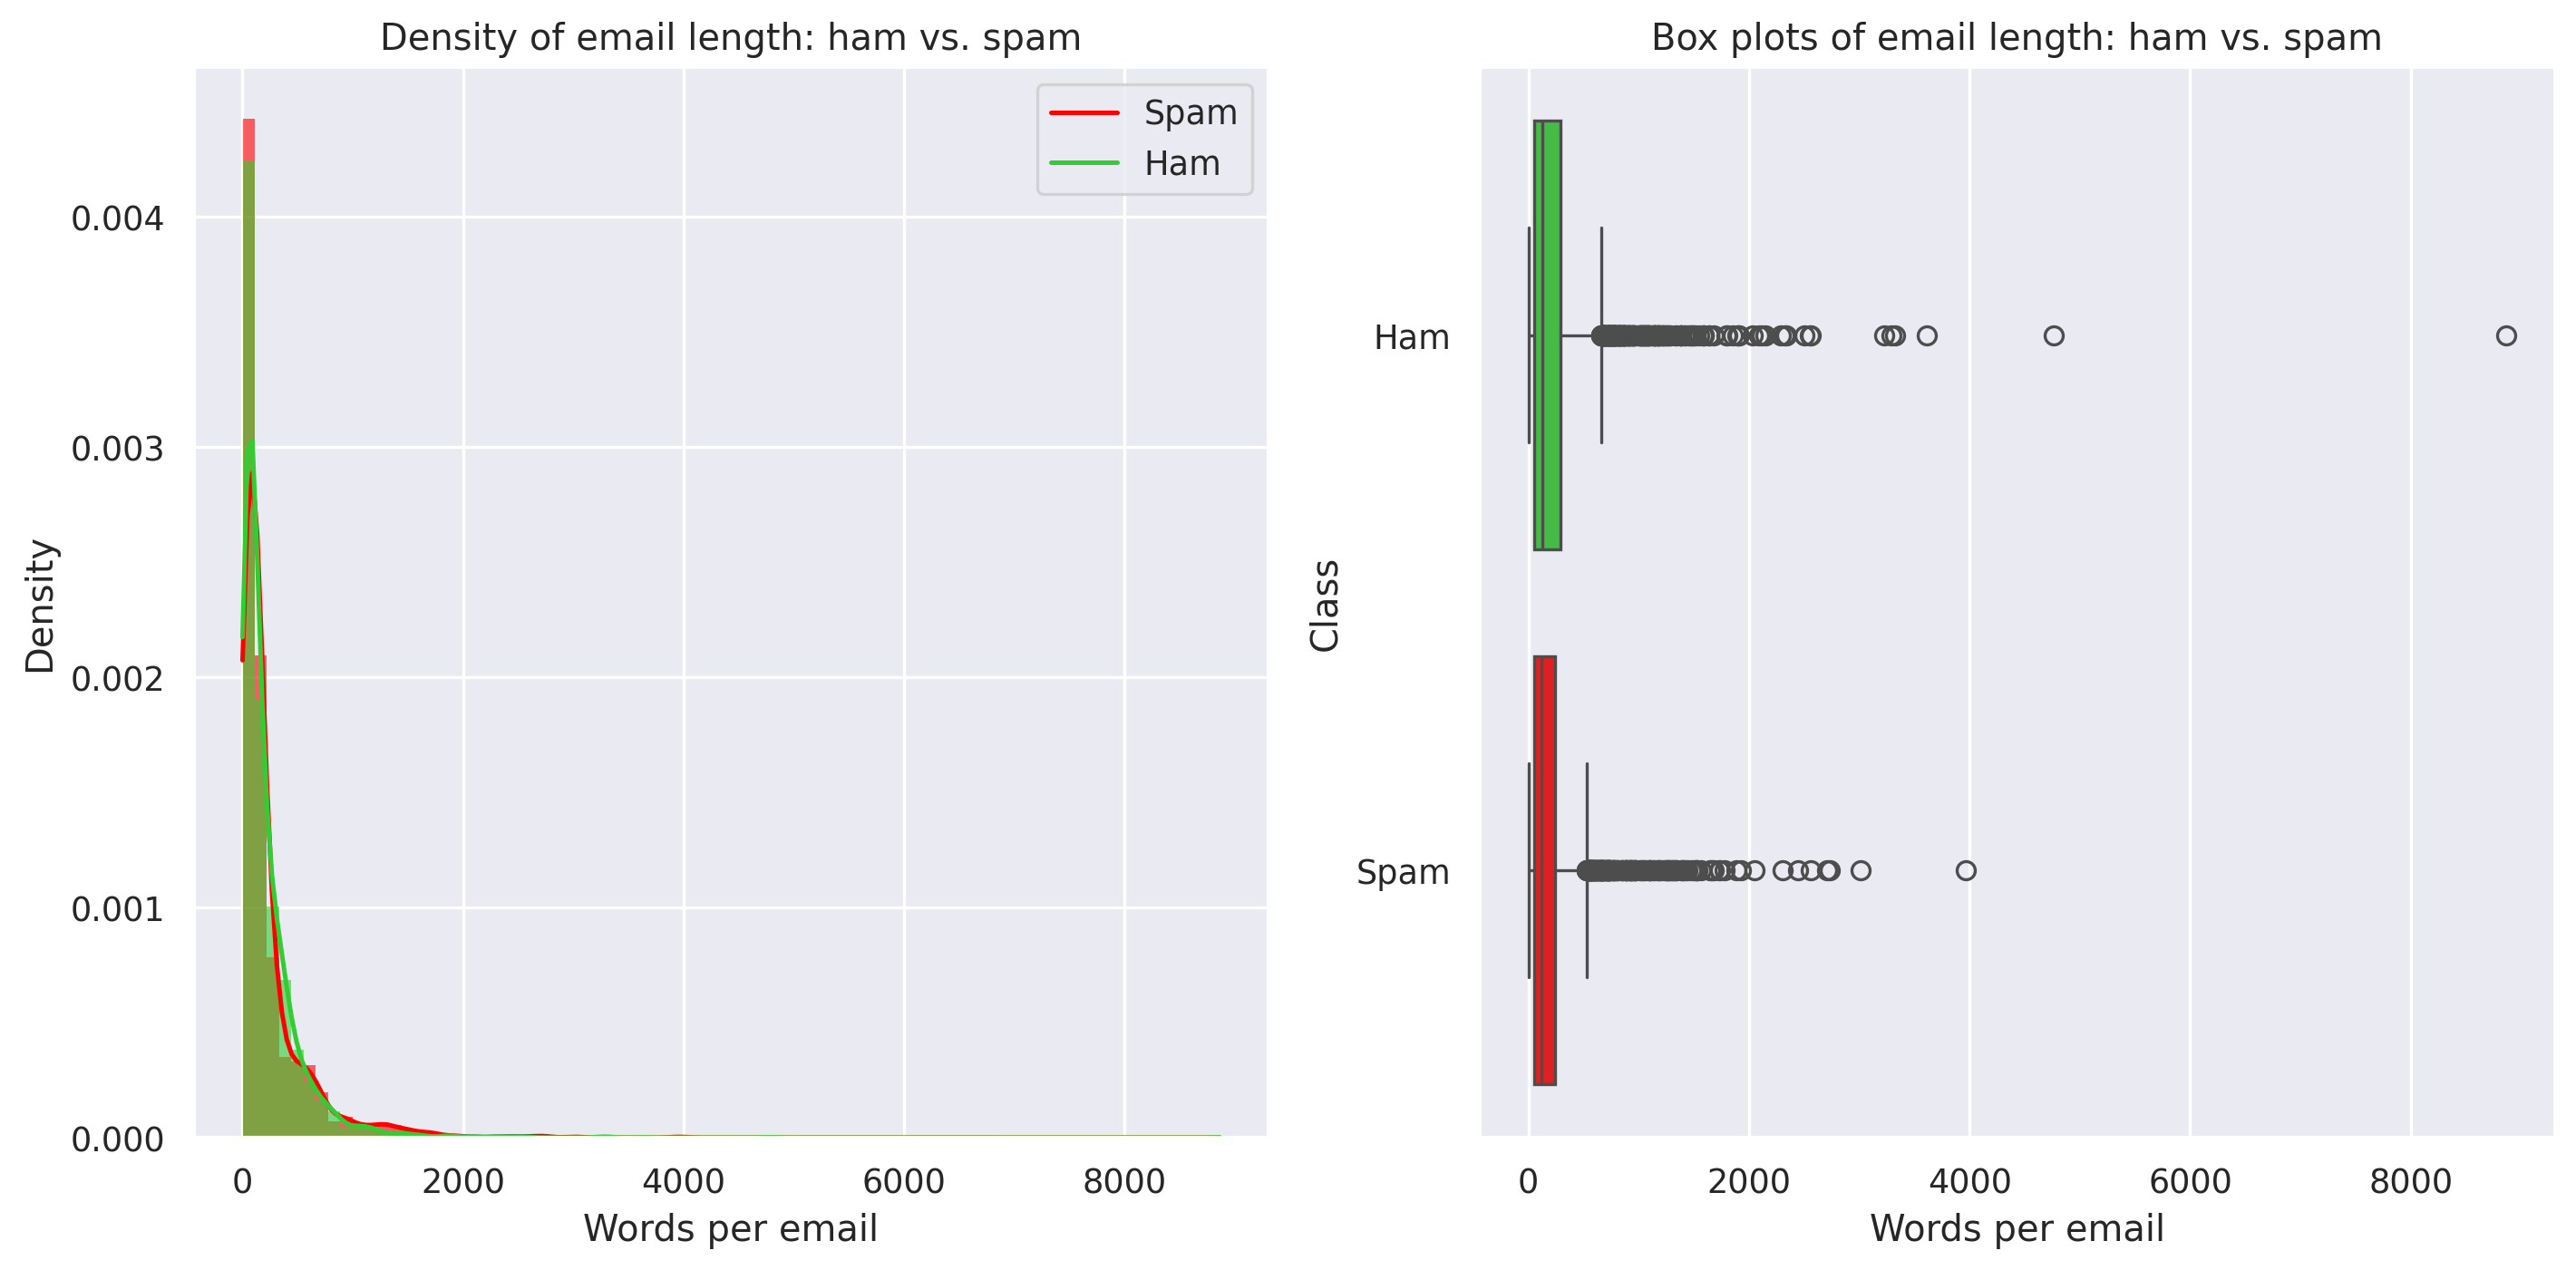

In [13]:
# Length distribution of ham vs spam emails
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=df, x='word_count', hue='label', palette=['limegreen','red'], bins=80,
             kde=True, stat='density', common_norm=False, edgecolor='none', alpha=.6)
plt.xlabel("Words per email")
plt.title("Density of email length: ham vs. spam")
plt.legend(title='', labels=['Spam', 'Ham'])

plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='word_count', y='label', orient="y", hue='label',
            palette=['limegreen','red'], legend=False)
plt.xlabel("Words per email")
plt.ylabel("Class")
plt.yticks([0,1], ['Ham', 'Spam'])
plt.title("Box plots of email length: ham vs. spam")

plt.tight_layout()
plt.show()

In [14]:
# Calculate lenght distribution statistics of ham vs spam emails
df_len_stats_class = df.groupby('label')['word_count'].describe(percentiles=[.50, .75, .90, .95, .99]).T
df_len_stats_class

label,ham,spam
count,3672.000000,1499.000000
mean,226.239107,236.387592
std,332.179661,346.821249
min,3.000000,2.000000
50%,124.000000,116.000000
75%,294.000000,244.000000
90%,521.900000,601.200000
95%,734.000000,893.300000
99%,1419.290000,1654.400000
max,8863.000000,3963.000000


Here, the distribution of average word length per email (overall and by class) is explored.

In [15]:
# Compute per-email average word length
df['avg_word_len'] = tokens_col.apply(lambda toks: (sum(len(t) for t in toks) / len(toks)))

In [16]:
df[['text','word_count','avg_word_len']].head()

,text,word_count,avg_word_len
0,Subject: enron methanol ; meter # : 988291\nth...,68,3.764706
1,"Subject: hpl nom for january 9 , 2001\n( see a...",24,3.041667
2,"Subject: neon retreat\nho ho ho , we ' re arou...",551,3.568058
3,"Subject: photoshop , windows , office . cheap ...",49,7.265306
4,Subject: re : indian springs\nthis deal is to ...,71,3.704225


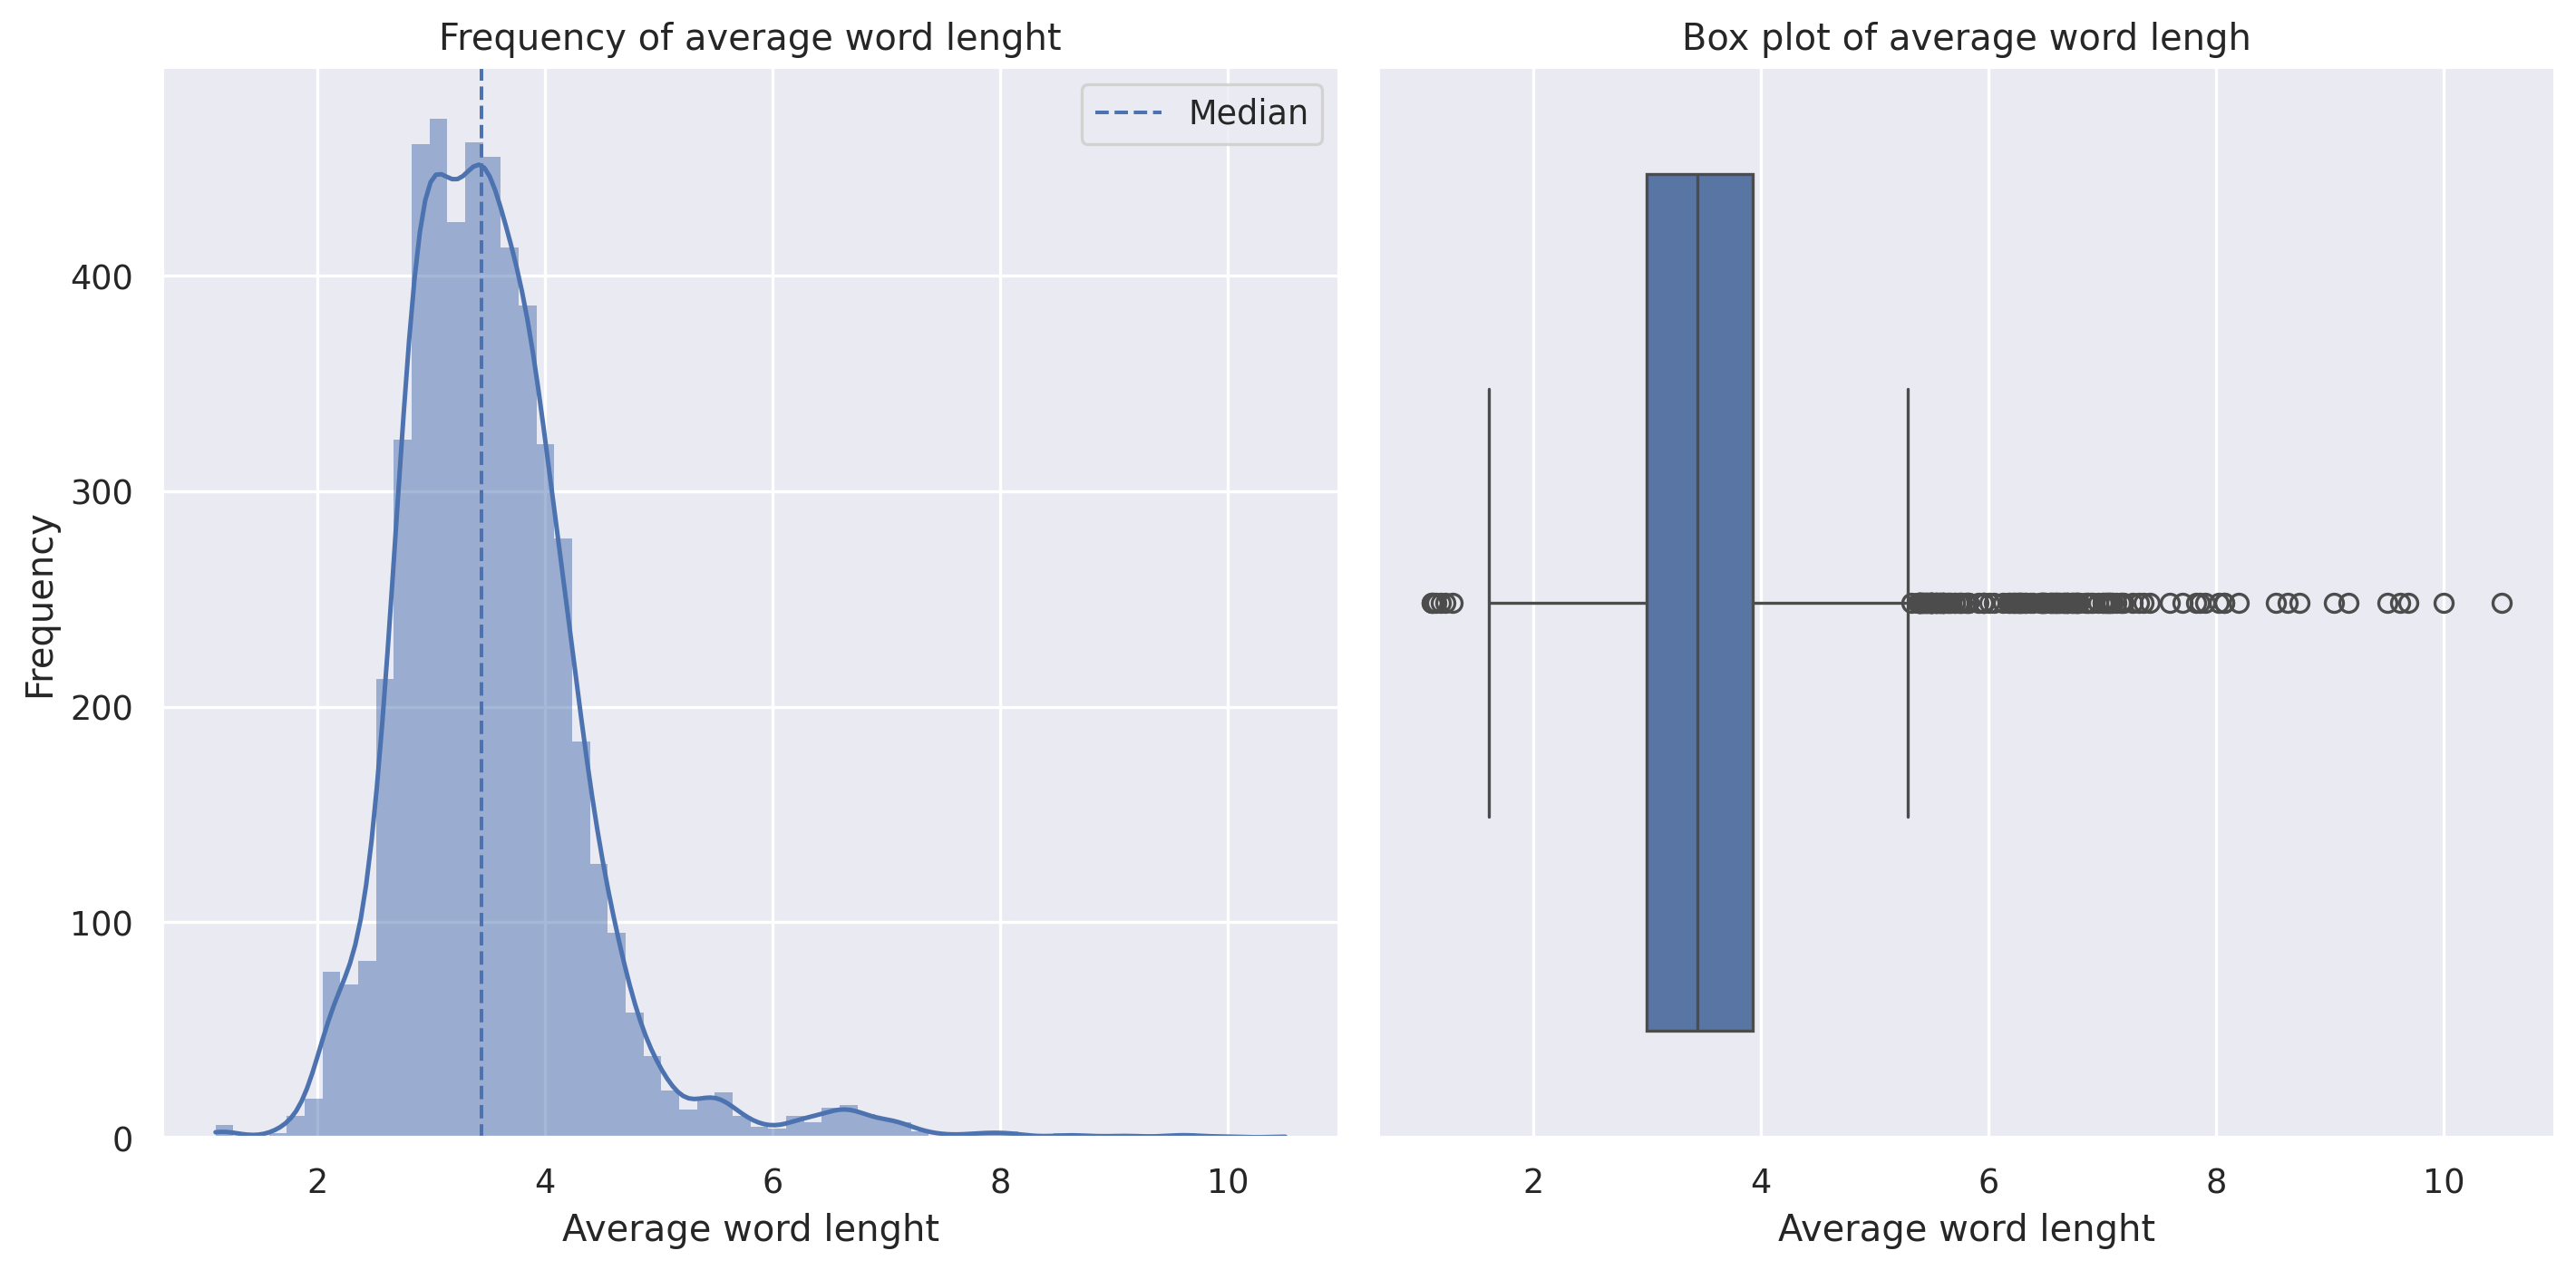

In [17]:
# Overall average word lenght distribution in each email

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
sns.histplot(df['avg_word_len'], bins=60, kde=True, edgecolor='none')
plt.axvline(df['avg_word_len'].median(), ls='--', lw=1.2, label='Median')
plt.xlabel("Average word lenght")
plt.ylabel("Frequency")
plt.title("Frequency of average word lenght")
plt.legend()

plt.subplot(1, 2, 2)
bp = sns.boxplot(df['avg_word_len'], orient="y")
plt.xlabel("Average word lenght")
plt.title("Box plot of average word lengh")

plt.tight_layout()
plt.show()

In [18]:
# Calculate average word lenght statistics of emails (overall)
df_avg_word_len_stats = df['avg_word_len'].describe(percentiles=[.50, .75, .90, .95, .99])
df_avg_word_len_stats

,avg_word_len
count,5171.000000
mean,3.534628
std,0.830411
min,1.106208
50%,3.445378
75%,3.925926
90%,4.388889
95%,4.771763
99%,6.711708
max,10.505882


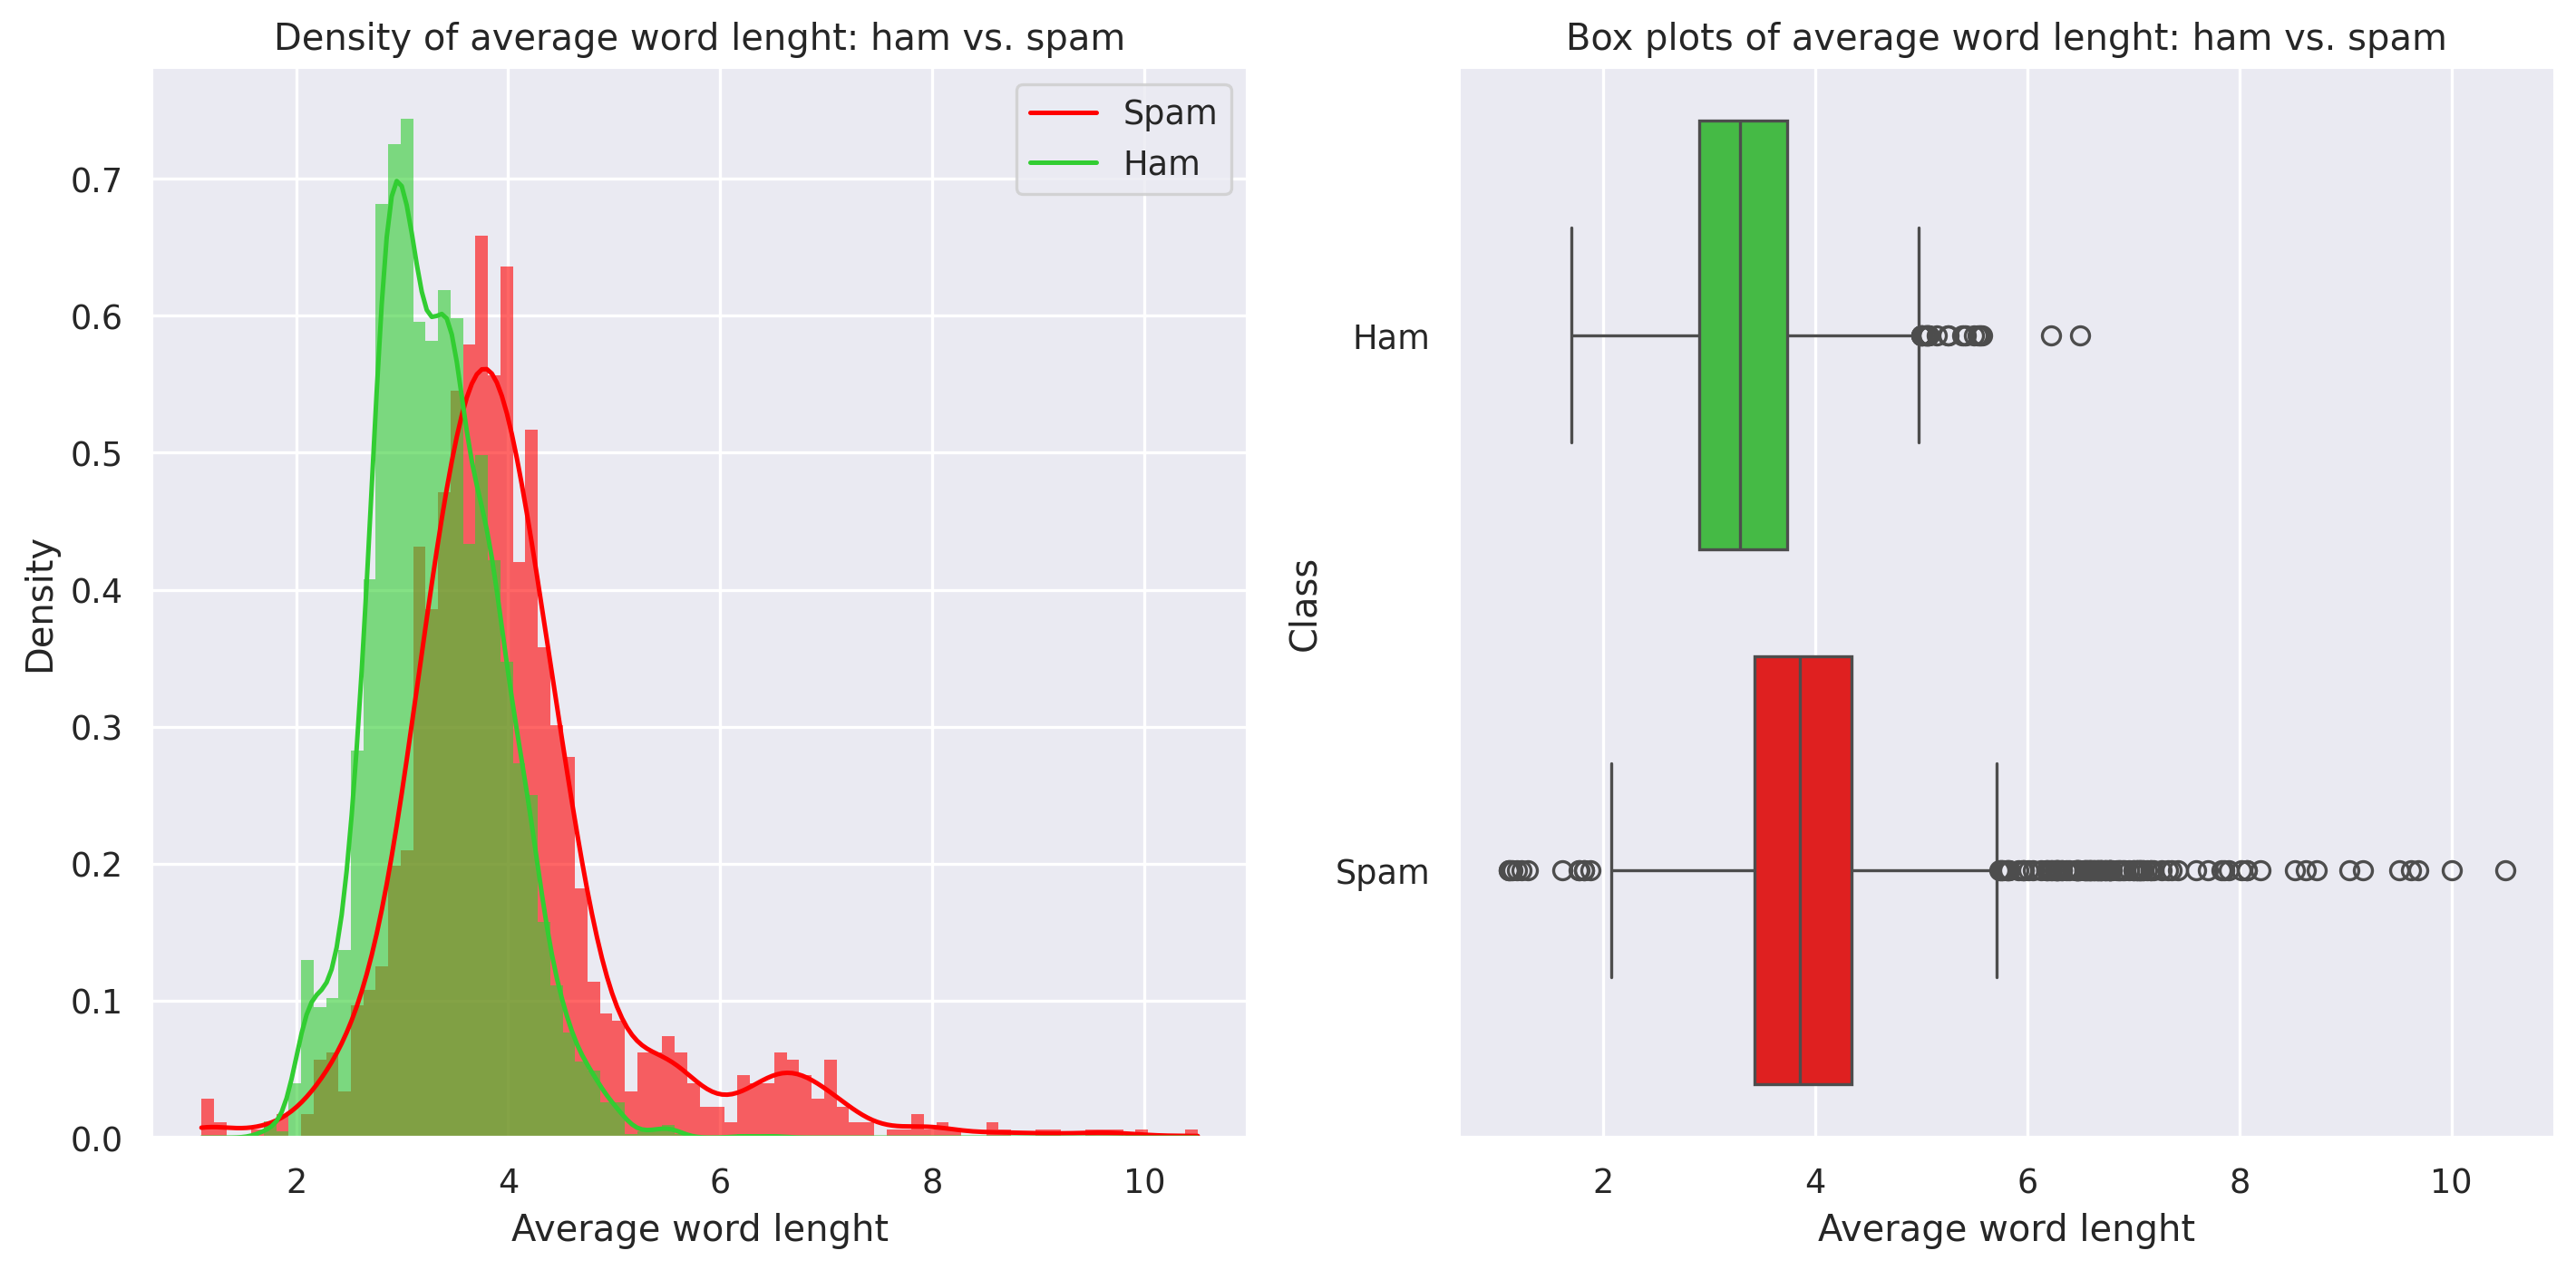

In [19]:
# Average word lenght distribution in ham vs spam emails
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=df, x='avg_word_len', hue='label', palette=['limegreen','red'], bins=80,
             kde=True, stat='density', common_norm=False, edgecolor='none', alpha=.6)
plt.xlabel("Average word lenght")
plt.title("Density of average word lenght: ham vs. spam")
plt.legend(title='', labels=['Spam', 'Ham'])

plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='avg_word_len', y='label', orient="y", hue='label',
            palette=['limegreen','red'], legend=False)
plt.xlabel("Average word lenght")
plt.ylabel("Class")
plt.yticks([0,1], ['Ham', 'Spam'])
plt.title("Box plots of average word lenght: ham vs. spam")

plt.tight_layout()
plt.show()

In [20]:
# Calculate average word lenght statistics statistics of ham vs spam emails
df_avg_word_len_stats_class = df.groupby('label')['avg_word_len'].describe(percentiles=[.50, .75, .90, .95, .99]).T
df_avg_word_len_stats_class

label,ham,spam
count,3672.000000,1499.000000
mean,3.333685,4.026867
std,0.597275,1.079016
min,1.700000,1.106208
50%,3.286008,3.853659
75%,3.733553,4.343634
90%,4.120917,5.264533
95%,4.349171,6.468296
99%,4.846685,7.858065
max,6.500000,10.505882


Lastly, the distribution of word length in the whole corpus (overall and by class) is explored.

In [21]:
# Compute word length across the entire dataset (overall and by class)

all_word_lengths = []
ham_word_lengths = []
spam_word_lengths = []

for tokens, label in zip(tokens_col, df["label"]):
    lengths = [len(t) for t in tokens]
    all_word_lengths.extend(lengths)
    if label == "ham":
        ham_word_lengths.extend(lengths)
    else:
        spam_word_lengths.extend(lengths)

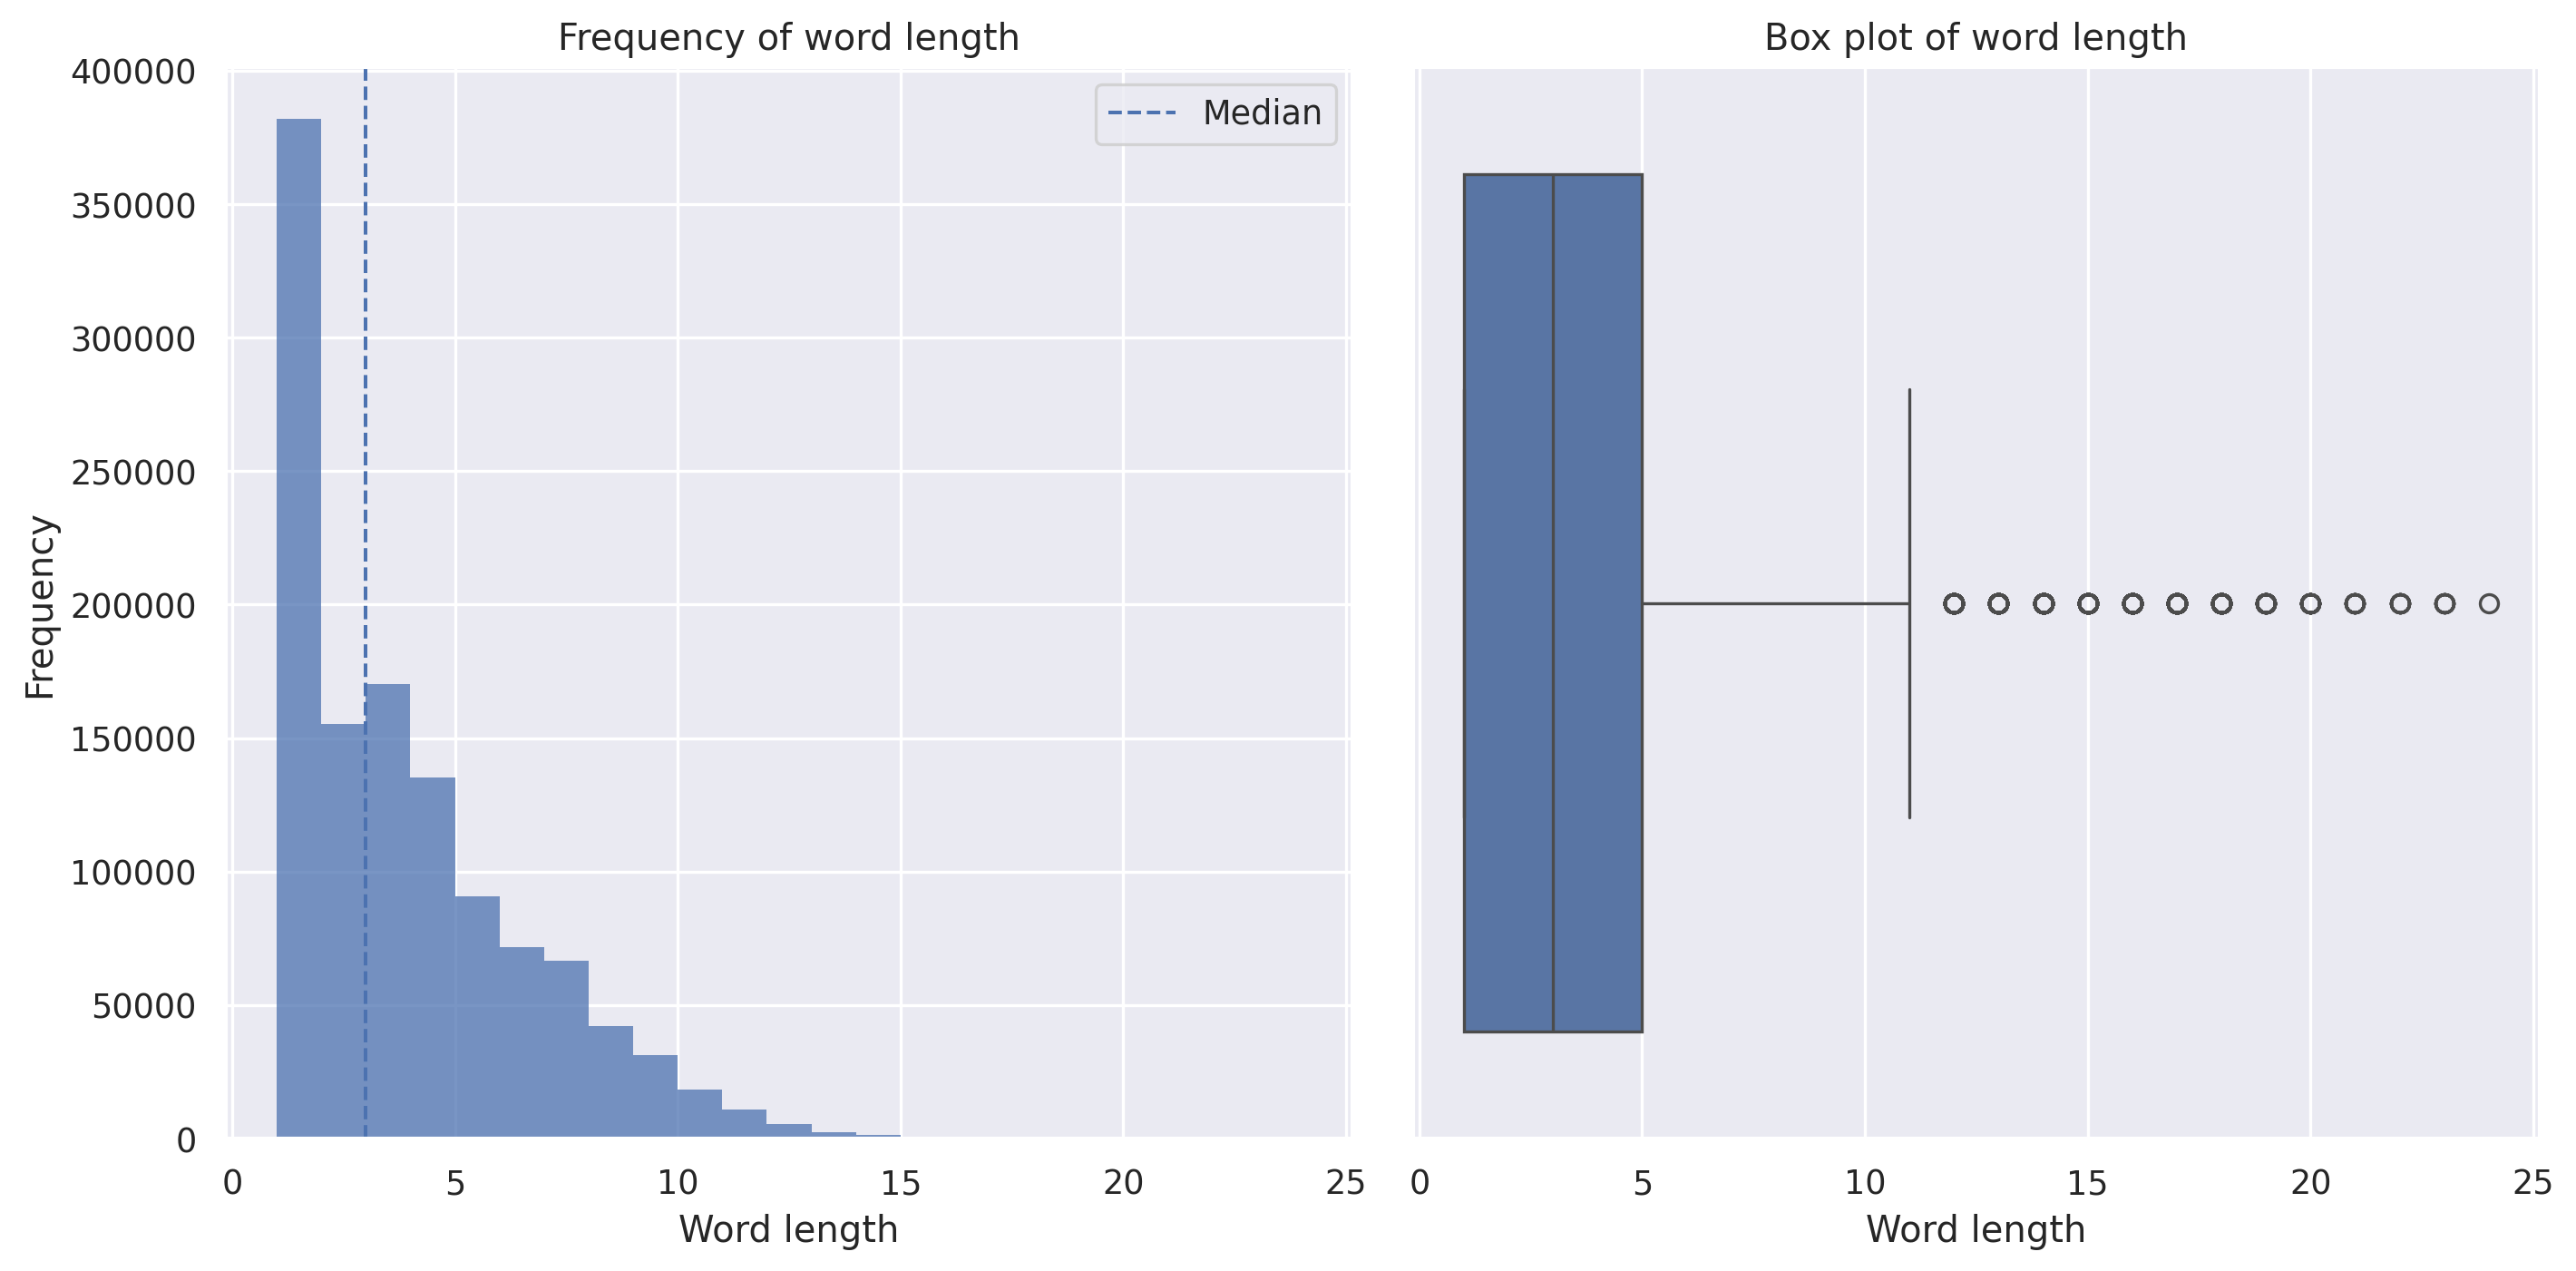

In [22]:
# Overall word length distribution across the entire dataset

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
sns.histplot(all_word_lengths, binwidth=1, kde=False, edgecolor='none')
plt.axvline(np.median(all_word_lengths), ls='--', lw=1.2, label='Median')
plt.xlabel("Word length")
plt.ylabel("Frequency")
plt.title("Frequency of word length")
plt.legend()

plt.subplot(1, 2, 2)
bp = sns.boxplot(all_word_lengths, orient="y")
plt.xlabel("Word length")
plt.title("Box plot of word length")

plt.tight_layout()
plt.show()

In [23]:
ham_spam_length_df = pd.DataFrame({'ham': pd.Series(ham_word_lengths), 'spam': pd.Series(spam_word_lengths)})
ham_spam_length_df_m = pd.melt(ham_spam_length_df, var_name="label").dropna()
ham_spam_length_df_m

,label,value
0,ham,7.0
1,ham,1.0
2,ham,5.0
3,ham,8.0
4,ham,1.0
...,...,...
1185090,spam,1.0
1185091,spam,9.0
1185092,spam,9.0
1185093,spam,5.0


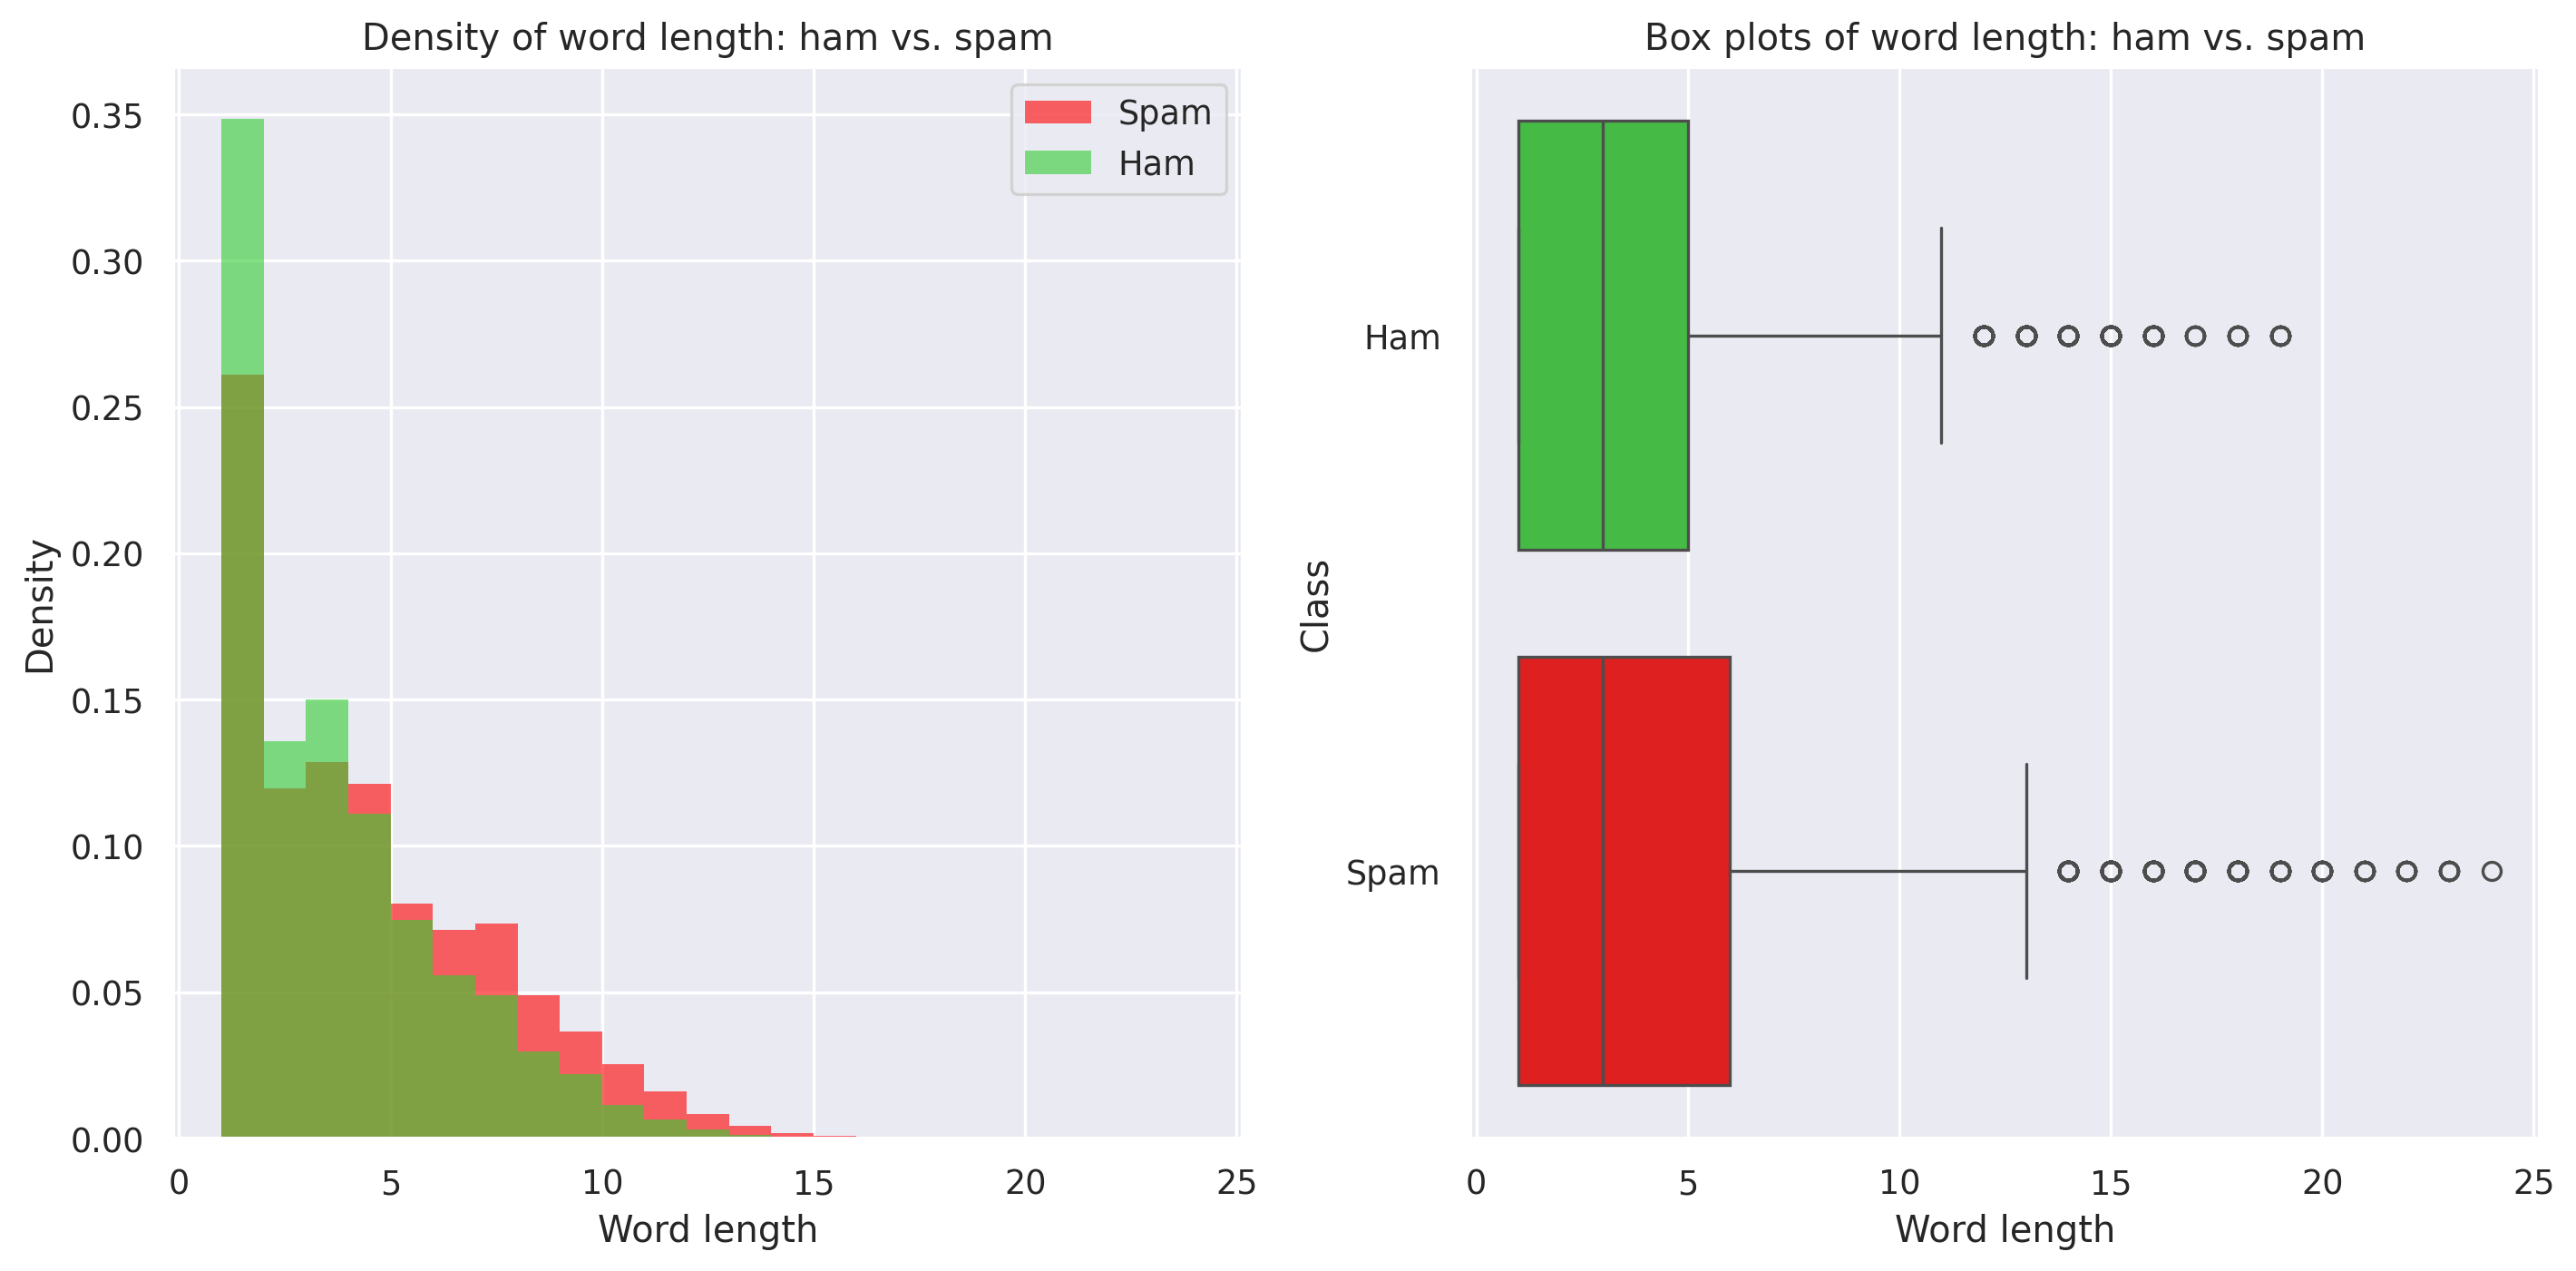

In [24]:
# Word length distribution in ham vs spam emails across the entire dataset

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=ham_spam_length_df_m, x='value', hue='label', palette=['limegreen','red'], binwidth=1,
             kde=False, stat='density', common_norm=False, edgecolor='none', alpha=.6)
plt.xlabel("Word length")
plt.title("Density of word length: ham vs. spam")
plt.legend(title='', labels=['Spam', 'Ham'])

plt.subplot(1, 2, 2)
sns.boxplot(data=ham_spam_length_df_m, x='value', y='label', orient="y", hue='label',
            palette=['limegreen','red'], legend=False)
plt.xlabel("Word length")
plt.ylabel("Class")
plt.yticks([0,1], ['Ham', 'Spam'])
plt.title("Box plots of word length: ham vs. spam")

plt.tight_layout()
plt.show()

In [25]:
all_word_length_df = pd.melt(pd.DataFrame({'overall': pd.Series(all_word_lengths)}), var_name="label")
word_length_df = pd.concat([all_word_length_df, ham_spam_length_df_m])
word_length_df

,label,value
0,overall,7.0
1,overall,1.0
2,overall,5.0
3,overall,8.0
4,overall,1.0
...,...,...
1185090,spam,1.0
1185091,spam,9.0
1185092,spam,9.0
1185093,spam,5.0


In [26]:
# Calculate word lenght statistics statistics across the entire dataset (overall and by class)
df_word_len_stats = word_length_df.groupby('label')['value'].describe(percentiles=[.50, .75, .90, .95, .99]).T
df_word_len_stats = df_word_len_stats[['overall', 'ham', 'spam']]
df_word_len_stats

label,overall,ham,spam
count,1.185095e+06,830750.000000,354345.000000
mean,3.504947e+00,3.252929,4.095794
std,2.668470e+00,2.482321,2.978366
min,1.000000e+00,1.000000,1.000000
50%,3.000000e+00,3.000000,3.000000
75%,5.000000e+00,5.000000,6.000000
90%,7.000000e+00,7.000000,8.000000
95%,9.000000e+00,8.000000,10.000000
99%,1.100000e+01,11.000000,12.000000
max,2.400000e+01,19.000000,24.000000


Considering the high frequency of words with 1-character length, a term frequency analysis will be performed after the preprocessing step.

## 2) Data preprocessing

In this phase, several cleaning and transformation methods are applied to the dataset in order to be properly processed by machine learning and other modeling algorithms.

### Cleaning of raw text

First, a basic text cleaning is perfomed: the [*simple_preprocess*](https://tedboy.github.io/nlps/generated/generated/gensim.utils.simple_preprocess.html) function from [**Gensim**](https://radimrehurek.com/gensim/) applies tokenization, lowercasing, removing of digits/punctuation and normalization (the minimum token length is set to 2 and the maximum token length to the 99th percentile of word length across the entire dataset), while English stopwords from the [**NLTK**](https://www.nltk.org/) library are removed.

In [27]:
# Download the list of stop words
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [28]:
# Set the maximum token length to 99th percentile of word length in the email dataset
MAX_LEN = int(df_word_len_stats.loc["99%", "overall"])

# Define a cleaning function to be applied to the email text
def preprocess_tokens(text):

    # Apply gensim simple_preprocess (tokenize, lowercase, de-accent and normalize)
    toks = simple_preprocess(text, deacc=True, min_len=2, max_len=MAX_LEN)

    # Drop stop-words
    toks = [t for t in toks if t not in STOPWORDS]

    return toks

In [29]:
# Apply the cleaning function to get a token column
df['tokens'] = df['text'].astype(str).apply(preprocess_tokens)

# Get a clean email text column
df['clean_text'] = df['tokens'].apply(lambda toks: ' '.join(toks))

df[['label', 'text', 'clean_text', 'tokens']].head()

,label,text,clean_text,tokens
0,ham,Subject: enron methanol ; meter # : 988291\nth...,subject enron methanol meter follow note gave ...,"[subject, enron, methanol, meter, follow, note..."
1,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",subject hpl nom january see attached file hpln...,"[subject, hpl, nom, january, see, attached, fi..."
2,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",subject neon retreat ho ho ho around wonderful...,"[subject, neon, retreat, ho, ho, ho, around, w..."
3,spam,"Subject: photoshop , windows , office . cheap ...",subject photoshop windows office cheap main tr...,"[subject, photoshop, windows, office, cheap, m..."
4,ham,Subject: re : indian springs\nthis deal is to ...,subject indian springs deal book teco pvr reve...,"[subject, indian, springs, deal, book, teco, p..."


In [30]:
# Re-compute word counts on the cleaned column
df['word_count_clean'] = df['clean_text'].str.split().apply(len)

# Email lenght statistics before and after cleaning
df_len_stats = df[['word_count', 'word_count_clean']].describe(percentiles=[.50, .75, .90, .95, .99])
df_len_stats

,word_count,word_count_clean
count,5171.000000,5171.000000
mean,229.181009,93.291046
std,336.487397,143.777249
min,2.000000,1.000000
50%,122.000000,47.000000
75%,283.500000,106.000000
90%,548.000000,220.000000
95%,766.000000,327.000000
99%,1504.600000,694.900000
max,8863.000000,3227.000000


### Term frequency analysis

Here, a quick term frequency analysis is performed on the cleaned dataset by counting occurrences of each word in the corpus and visualizing the most common words.

In [31]:
# Get the tokens list for the whole corpus
all_tokens = [t for toks in df['tokens'] for t in toks]

# Calculate term frequency
tf_counter = Counter(all_tokens)

# Get the list of most common words
top_words = tf_counter.most_common(20)
words, freqs = zip(*top_words)

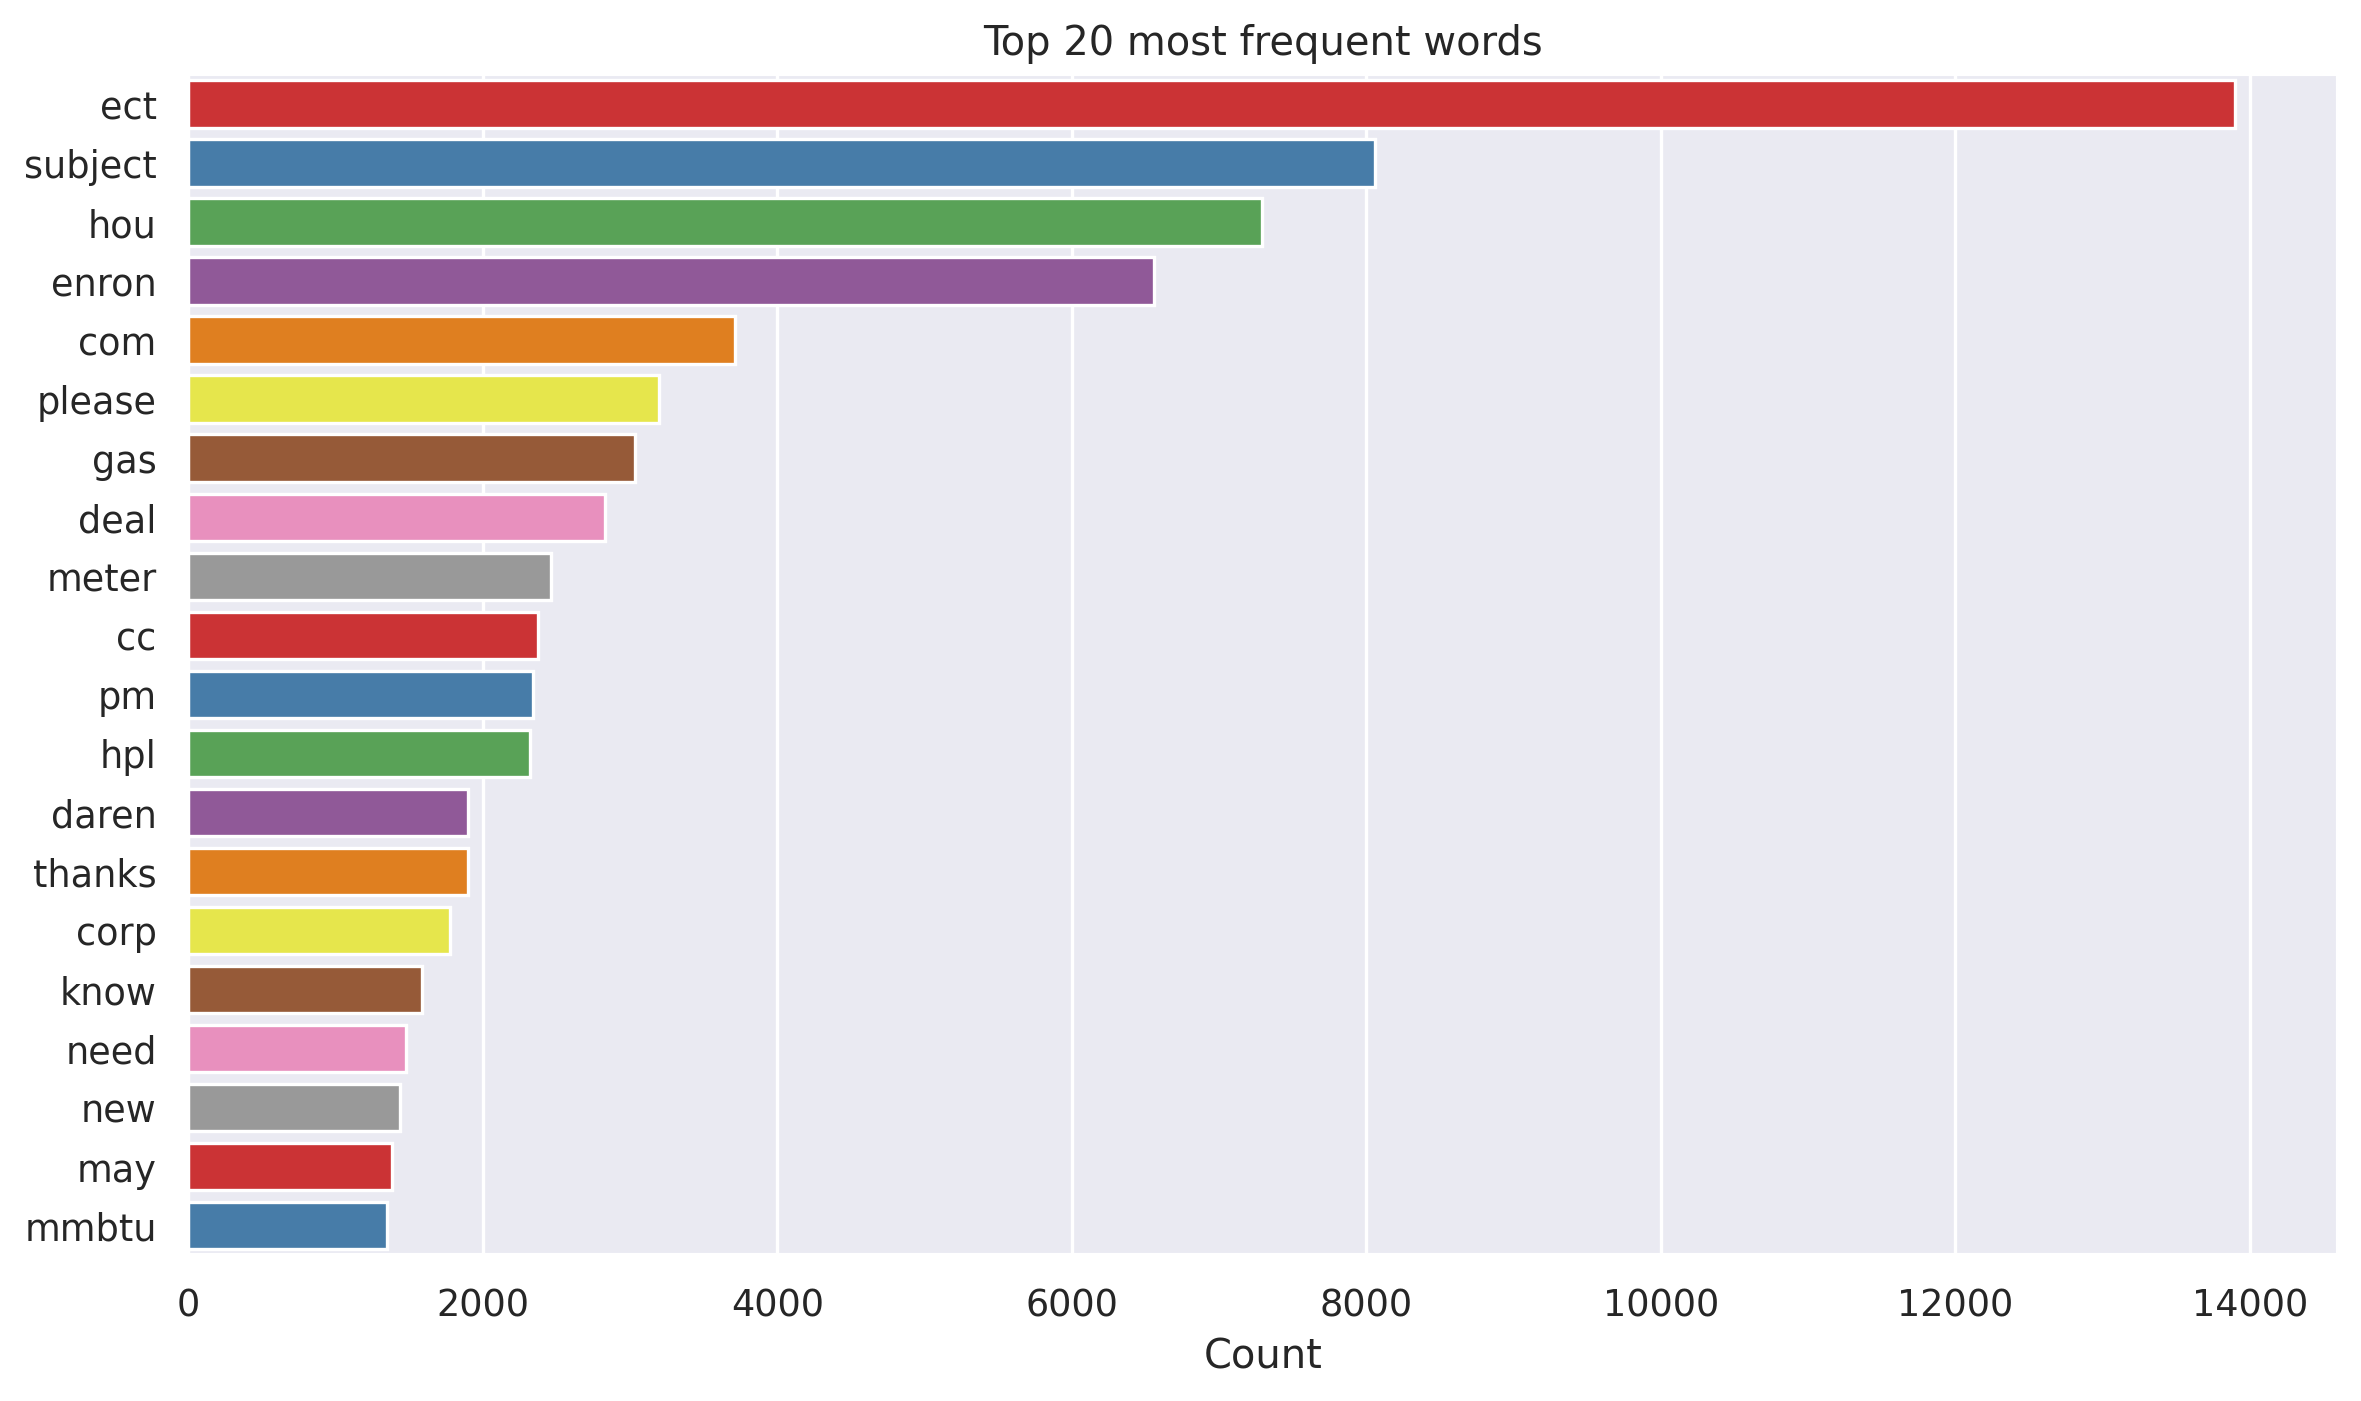

In [32]:
# Visualize the top 20 most common words
plt.figure(figsize=(10,6))
sns.barplot(x=freqs, y=words, hue=words, palette="Set1")
plt.xlabel("Count")
plt.title('Top 20 most frequent words')

plt.tight_layout()
plt.show()

### Stratified Train/Test split

Here, the dataset is split into train/test sets, using stratification to preserve class proportions.

In [33]:
# Assign the email text and label column to the X,y variables
X = df['clean_text']
y = df['label_num']

print(f"Dataset shape before splitting: \n X: {X.shape} \n y: {y.shape}")

Dataset shape before splitting: 
 X: (5171,) 
 y: (5171,)


In [34]:
# Splitting data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [35]:
print(f"\nTrain dataset size: {X_train.shape[0]} samples")
print("Distribution of ham vs spam emails (train dataset):")
print(f"  0 (Ham): {Counter(y_train)[0]}")
print(f"  1 (Spam): {Counter(y_train)[1]}")

print(f"\nTest dataset size: {X_test.shape[0]} samples")
print("Distribution of ham vs spam emails (test dataset):")
print(f"  0 (Ham): {Counter(y_test)[0]}")
print(f"  1 (Spam): {Counter(y_test)[1]}")


Train dataset size: 4136 samples
Distribution of ham vs spam emails (train dataset):
  0 (Ham): 2937
  1 (Spam): 1199

Test dataset size: 1035 samples
Distribution of ham vs spam emails (test dataset):
  0 (Ham): 735
  1 (Spam): 300


### Vectorization to TF-IDF features

Here, all email samples in the train and test sets are vectorized, namely converted from text into numeric data, which can be used as input for machine learning and other algorithms.

First, [*TfidfVectorizer*](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) is applied, consisting in a method to convert text data into numerical form by counting the frequency of each word and assigning a weight to each word based on its frequency in the document and its frequency in the entire corpus. The resulting vectorized data will be used to train a Multinomial Naive Bayes classifier.

In [36]:
# Initialize the TF-IDF vectorizer
tfidf = TfidfVectorizer()

# Fit and transform the text training data
X_train_tfidf = tfidf.fit_transform(X_train)

# Transform the text testing data
X_test_tfidf = tfidf.transform(X_test)

print("X_train_tfidf shape:", X_train_tfidf.shape)
print("X_test_tfidf shape:", X_test_tfidf.shape)

X_train_tfidf shape: (4136, 36843)
X_test_tfidf shape: (1035, 36843)


### Vectorization to sequences of integers

Here, the train and test sets are coverted into integer sequences, consisting of lists of token indices from a vocabulary created from the dataset. For this process, [*TextVectorization*](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) from tf.keras.layers will be used. This layer is designed to handle natural language inputs for Tensorflow Keras models and the resulting vectorized data will be used to train a Recurrent Neural Network model.

While the vocabulary is built directly from the text dataset, it can be capped to a maximum size, which in this case will be set to a number covering 95% of words occurrence in the dataset. Moreover, the length of the output sequences will be set to the 95th percentile of comments length. Text inputs of lower and higher lengths are padded or truncated, resulting in a standardized output dimension.

In [37]:
# Calculate the vocabulary size that covers 95% of word occurrences
word_counts = Counter(" ".join(X_train).split())
tot_words  = sum(word_counts.values())
cum, vocab_size = 0, 0
for tok, freq in word_counts.most_common():
    cum += freq
    vocab_size += 1
    if cum / tot_words >= 0.95:
        break

In [38]:
print(f"Total words in the train dataset: {tot_words}")
print(f"Unique words in the train dataset: {len(word_counts)}")
print(f"Vocabulary size covering 95% of word occurrences (train): {vocab_size}")

Total words in the train dataset: 382798
Unique words in the train dataset: 36843
Vocabulary size covering 95% of word occurrences (train): 17704


In [39]:
# Set the sequence length to 95th percentile of cleaned email length
SEQ_LEN = int(df_len_stats.loc["95%", "word_count_clean"])
print(f"Length of the output sequence: {SEQ_LEN}")

Length of the output sequence: 327


In [40]:
# Convert train and test datasets from text to integer sequences (vectorization)

# Create the vectorizer layer
vectorizer = TextVectorization(
    max_tokens=vocab_size,
    standardize=None,
    split='whitespace',
    output_mode='int',
    output_sequence_length=SEQ_LEN
)

# Build the vocabulary based on the text dataset
vectorizer.adapt(X_train)

# Convert text to sequences of integers
X_train_seq = vectorizer(X_train).numpy()
X_test_seq  = vectorizer(X_test).numpy()

In [41]:
print("Sequence feature matrix shapes:")
print(f"  Train: {X_train_seq.shape}")
print(f"  Test:  {X_test_seq.shape}")

Sequence feature matrix shapes:
  Train: (4136, 327)
  Test:  (1035, 327)


In [42]:
# Visualize examples of original comment text and the corresponding sequence
for i in range(5):
    print(f"Comment: {' '.join(X_train.values[i].split()[:12])} ...")
    print(f"Sequence: {X_train_seq[i][:12]} ...\n")

Comment: subject hstoett lady sucklng huge ccok pleasure squire kuwo ...
Sequence: [    3     1  3268     1  1224 16404  2464     1     1     0     0     0] ...

Comment: subject lose powerful weightloss available hello special offer want lose weight powerful ...
Sequence: [   3  885 2186 3948  120 1041  279  298   72  885  957 2186] ...

Comment: subject hi daren attempting clear mentioned meter error report revenue volume comparison ...
Sequence: [   3  452   15 5897  554  853   10  456   70 1137   39 3162] ...

Comment: subject nd rev mar josey ranch nom forwarded susan trevino hou ect ...
Sequence: [   3  569 1641 1010 1496  481   44   22  184 1190    4    2] ...

Comment: subject lose os os aaiabe learn unlist ...
Sequence: [   3  885 3819 3819    1  978    1    0    0    0    0    0] ...



### Balancing of the training dataset

As observed in the exploratory analysis, the labels are unevenly distributed among classes. This **data imbalance** can greatly affect the performance of classification algorithms.

To overcome this problem, the approach of **data augmentation** by synthesizing new samples from the minority class can be used. ***Synthetic Minority Oversampling TEchnique*** ([**SMOTE**](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html)) is a method of data augmentation that works by selecting samples that are close in the feature space. Specifically, the approach of SMOTE is the following: a random sample from the minority class is chosen; k nearest neighbors for that sample are found; a randomly selected neighbor is chosen and a synthetic sample is created at a randomly selected point between the two samples in the feature space.

Here, the SMOTE algorithm will be used to balance the training dataset with TF-IDF features. The test dataset will not be modified, to evaluate the performance of the classification model with a realistic distribution of classes.

In [43]:
# Original dataset
datasets = {
    "Original": (X_train_tfidf, y_train)
}

In [44]:
# Apply SMOTE to balance the TF-IDF training set

smote = SMOTE(random_state=42)
X_train_tfidf_bal, y_train_tfidf_bal = smote.fit_resample(X_train_tfidf, y_train)

datasets["Oversampled"] = (X_train_tfidf_bal, y_train_tfidf_bal)

In [45]:
print(f"Class distribution before SMOTE:")
print(f"  0 (Ham): {Counter(y_train)[0]}")
print(f"  1 (Spam): {Counter(y_train)[1]}")

print(f"\nClass distribution after SMOTE:")
print(f"  0 (Ham): {Counter(y_train_tfidf_bal)[0]}")
print(f"  1 (Spam): {Counter(y_train_tfidf_bal)[1]}")

Class distribution before SMOTE:
  0 (Ham): 2937
  1 (Spam): 1199

Class distribution after SMOTE:
  0 (Ham): 2937
  1 (Spam): 2937


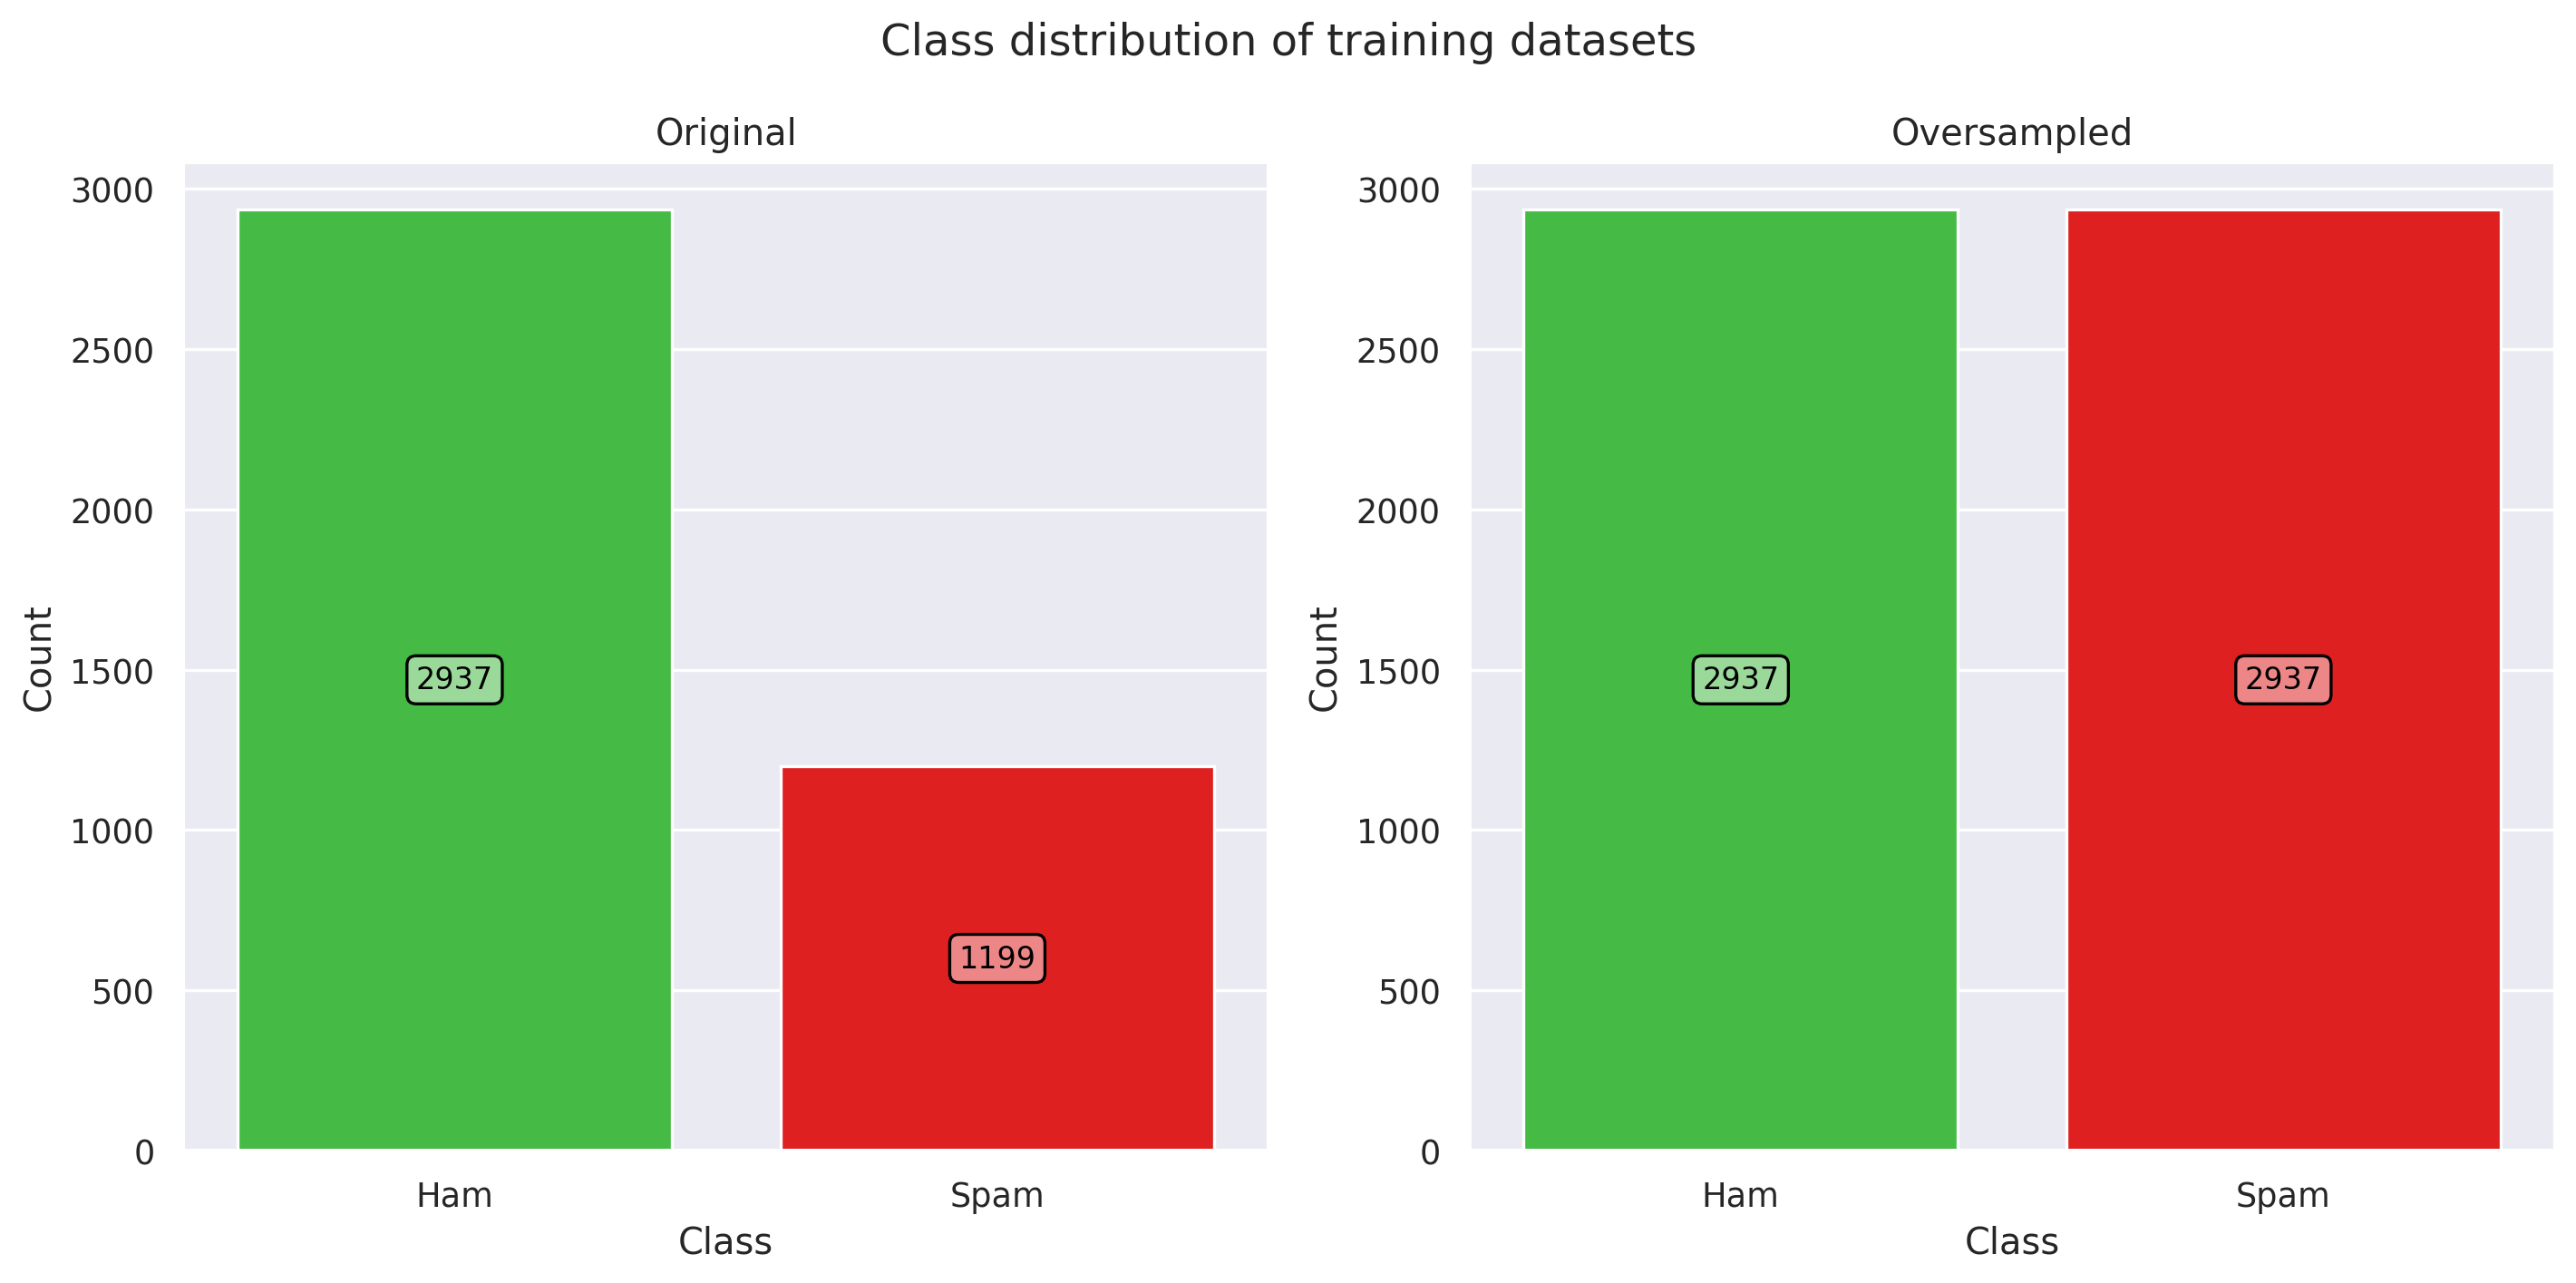

In [46]:
# Count plots to visualize the class distributions of emails in the training datasets

plt.figure(figsize=(12, 6))

for i, dataset in enumerate(datasets.keys()):

    plt.subplot(1, 2, i+1)
    sns.countplot(x=datasets[dataset][1], hue=datasets[dataset][1], palette=['limegreen','red'], legend=False)
    plt.title(dataset, fontsize=12)
    plt.xlabel('Class')
    plt.xticks(ticks=[0,1], labels=["Ham", "Spam"])
    plt.ylabel('Count')

    for i, count in Counter(datasets[dataset][1]).items():
        plt.annotate(f"{count}",
                     xy=(i, count/2),
                     ha='center', va='center',
                     fontsize=10, color='black',
                     bbox = dict(boxstyle="round", ec='black', fc="#ffffff75"))

plt.suptitle("Class distribution of training datasets")
plt.tight_layout()
plt.show()

## 3) Classification Model training

In this section, two machine learning models will be trained to classify SPAM and non-SPAM emails and evaluated.

In [47]:
# Define a function to evaluate model performance on the test set

def evaluate_model(model, x_test, y_test):

    # Probability and binary predictions on test set
    if type(model) == keras.src.models.sequential.Sequential:
        y_proba = model.predict(x_test, batch_size=256, verbose=0)
        threshold = 0.5
        y_pred  = (y_proba >= threshold).astype(int)
    else:
        y_pred = model.predict(x_test)
        y_proba = model.predict_proba(x_test)[:, 1]

    # Calculate metrics
    metrics = {}
    metrics['accuracy'] = accuracy_score(y_test, y_pred)
    metrics['precision'] = precision_score(y_test, y_pred)
    metrics['recall'] = recall_score(y_test, y_pred)
    metrics['f1'] = f1_score(y_test, y_pred)
    metrics['roc_auc'] = roc_auc_score(y_test, y_proba)
    metrics['pr_auc'] = average_precision_score(y_test, y_proba)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Store results
    results = {
        'metrics': metrics,
        'confusion_matrix': cm,
        'predictions': y_proba
    }

    return results

### Multinomial Naive Bayes

The first approach considered is [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html), an implementation of the Naive Bayes algorithm for multinomially distributed data, suitable for classification with discrete features such as word counts, which assumes that all features are independent from each other. This model will be trained on the balanced TF-IDF dataset.

In [48]:
# Fit Multinomial NB model with balanced TF-IDF dataset
nb_tfidf_bal = MultinomialNB(alpha=1.0)  # Laplace smoothing
nb_tfidf_bal.fit(X_train_tfidf_bal, y_train_tfidf_bal)

MultinomialNB()

In [49]:
# Calculate NB model metrics on the test set
nb_tfidf_bal_res = evaluate_model(model=nb_tfidf_bal, x_test=X_test_tfidf, y_test=y_test)

print("Multinomial Naive Bayes classifier\n")
for metric, value in nb_tfidf_bal_res['metrics'].items():
    print(f" {metric+":":<15} {value:<15.4f} ")

Multinomial Naive Bayes classifier

 accuracy:       0.9710          
 precision:      0.9272          
 recall:         0.9767          
 f1:             0.9513          
 roc_auc:        0.9955          
 pr_auc:         0.9885          


### Recurrent Neural Network

The second appraoch considered is a Recurrent Neural Network that will be trained on the integer sequence dataset. The model consists of a deep learning architecture including a series of layer added in sequence, some of which specialized to process sequential data derived from text:
- the **Input** layer declares the expected shape of input samples, in this case a 1‑D sequence of integer tokens of fixed length;
- the **Embedding** layer maps integer tokens to embedding vectors of size 128 and include a masking to ensure that index 0 is treated as padding and ignored by recurrent layers in computations;
- the **SpatialDropout1D** layer has a regularization purpose, as it randomly drops entire embedding feature dimensions with probability 0.2 in order to prevent overfitting;
- the **Bidirectional** layer processes the vector sequences from both directions to capture contextual features from both past and future tokens: in this case two **GRU** (Gated Recurrent Unit) layers, a type of recurrent neural network designed to overcome the vanishing gradient problem, take the inputs, one in a forward direction and the other in a backwards direction, and output single vector representations;
- a **Dense** layer with a sigmoid activation function outputs a probability for the final classification.

In [ ]:
clear_session()

# Build the model
RNN_model = models.Sequential([
    layers.Input(shape=(SEQ_LEN,)),
    layers.Embedding(input_dim=vocab_size, output_dim=128, mask_zero=True),
    layers.SpatialDropout1D(0.2),
    layers.Bidirectional(layers.GRU(units=64, dropout=0.2, recurrent_dropout=0.2, return_sequences=False)),
    layers.Dense(1, activation='sigmoid')
])

RNN_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 327, 128)       │     2,266,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 327, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,340,737 (8.93 MB)

 Trainable params: 2,340,737 (8.93 MB)

 Non-trainable params: 0 (0.00 B)

When compiling the model, the *'binary cross-entropy'* is selected as loss function, calculating the cross-entropy loss between true labels and predicted labels for binary (0 or 1) classification. The *'adam'* optimizer, a common adaptive learning rate optimizer using the Adam algorithm is selected. Lastly, three metrics are selected to evaluate the model performance during training and validation:
- **Binary Accuracy**, computing the fraction of total labels whose predicted probability matches the true binary label;
- **Precision**, computing the fraction of true positive labels over all labels predicted positive;
- **Recall**, computing the fraction of predicted positive labels over all true positive labels.

Then, an early stopping callback is defined to stop training when a monitored metric, in this case the validation accuracy, has stopped improving. The number of epochs with no improvement after which training stops is set to 3.

In [ ]:
# Compile the model
RNN_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Define early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

Here, a validation dataset is split from the balanced training dataset (15%), using stratification, and will be used as validation data in the training phase.

In [ ]:
# Split validation set from the sequence training data (15%)

X_tr_seq, X_val_seq, y_tr, y_val = train_test_split(
    X_train_seq, y_train,
    test_size=0.15, random_state=42, stratify=y_train
)

print("Sequence feature matrix shapes:")
print(f"  Train:       {X_tr_seq.shape}")
print(f"  Validation:  {X_val_seq.shape}")

Sequence feature matrix shapes:
  Train:       (3515, 327)
  Validation:  (621, 327)


Lastly, the defined model is trained and the related learning curves tracking the peformance during training, based on the calculated metrics, are visualized.

In [ ]:
BATCH_SIZE = 64
EPOCHS = 5

# Train the model
history = RNN_model.fit(
    X_tr_seq, y_tr,
    validation_data=(X_val_seq, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.7360 - loss: 0.5055 - precision: 0.6628 - recall: 0.2278 - val_accuracy: 0.9581 - val_loss: 0.1591 - val_precision: 0.9326 - val_recall: 0.9222
Epoch 2/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9829 - loss: 0.0583 - precision: 0.9578 - recall: 0.9831 - val_accuracy: 0.9807 - val_loss: 0.0586 - val_precision: 0.9421 - val_recall: 0.9944
Epoch 3/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9900 - loss: 0.0324 - precision: 0.9664 - recall: 0.9982 - val_accuracy: 0.9936 - val_loss: 0.0316 - val_precision: 0.9889 - val_recall: 0.9889
Epoch 4/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9976 - loss: 0.0094 - precision: 0.9928 - recall: 0.9989 - val_accuracy: 0.9919 - val_loss: 0.0294 - val_precision: 0.9781 - val_recall: 0.9944
Epoch 5/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.9988 - loss: 0.0050 - precision: 0.9981 - recall: 0.9978 - val_accuracy: 0.9952 - val_loss: 0.0238 - val_prec

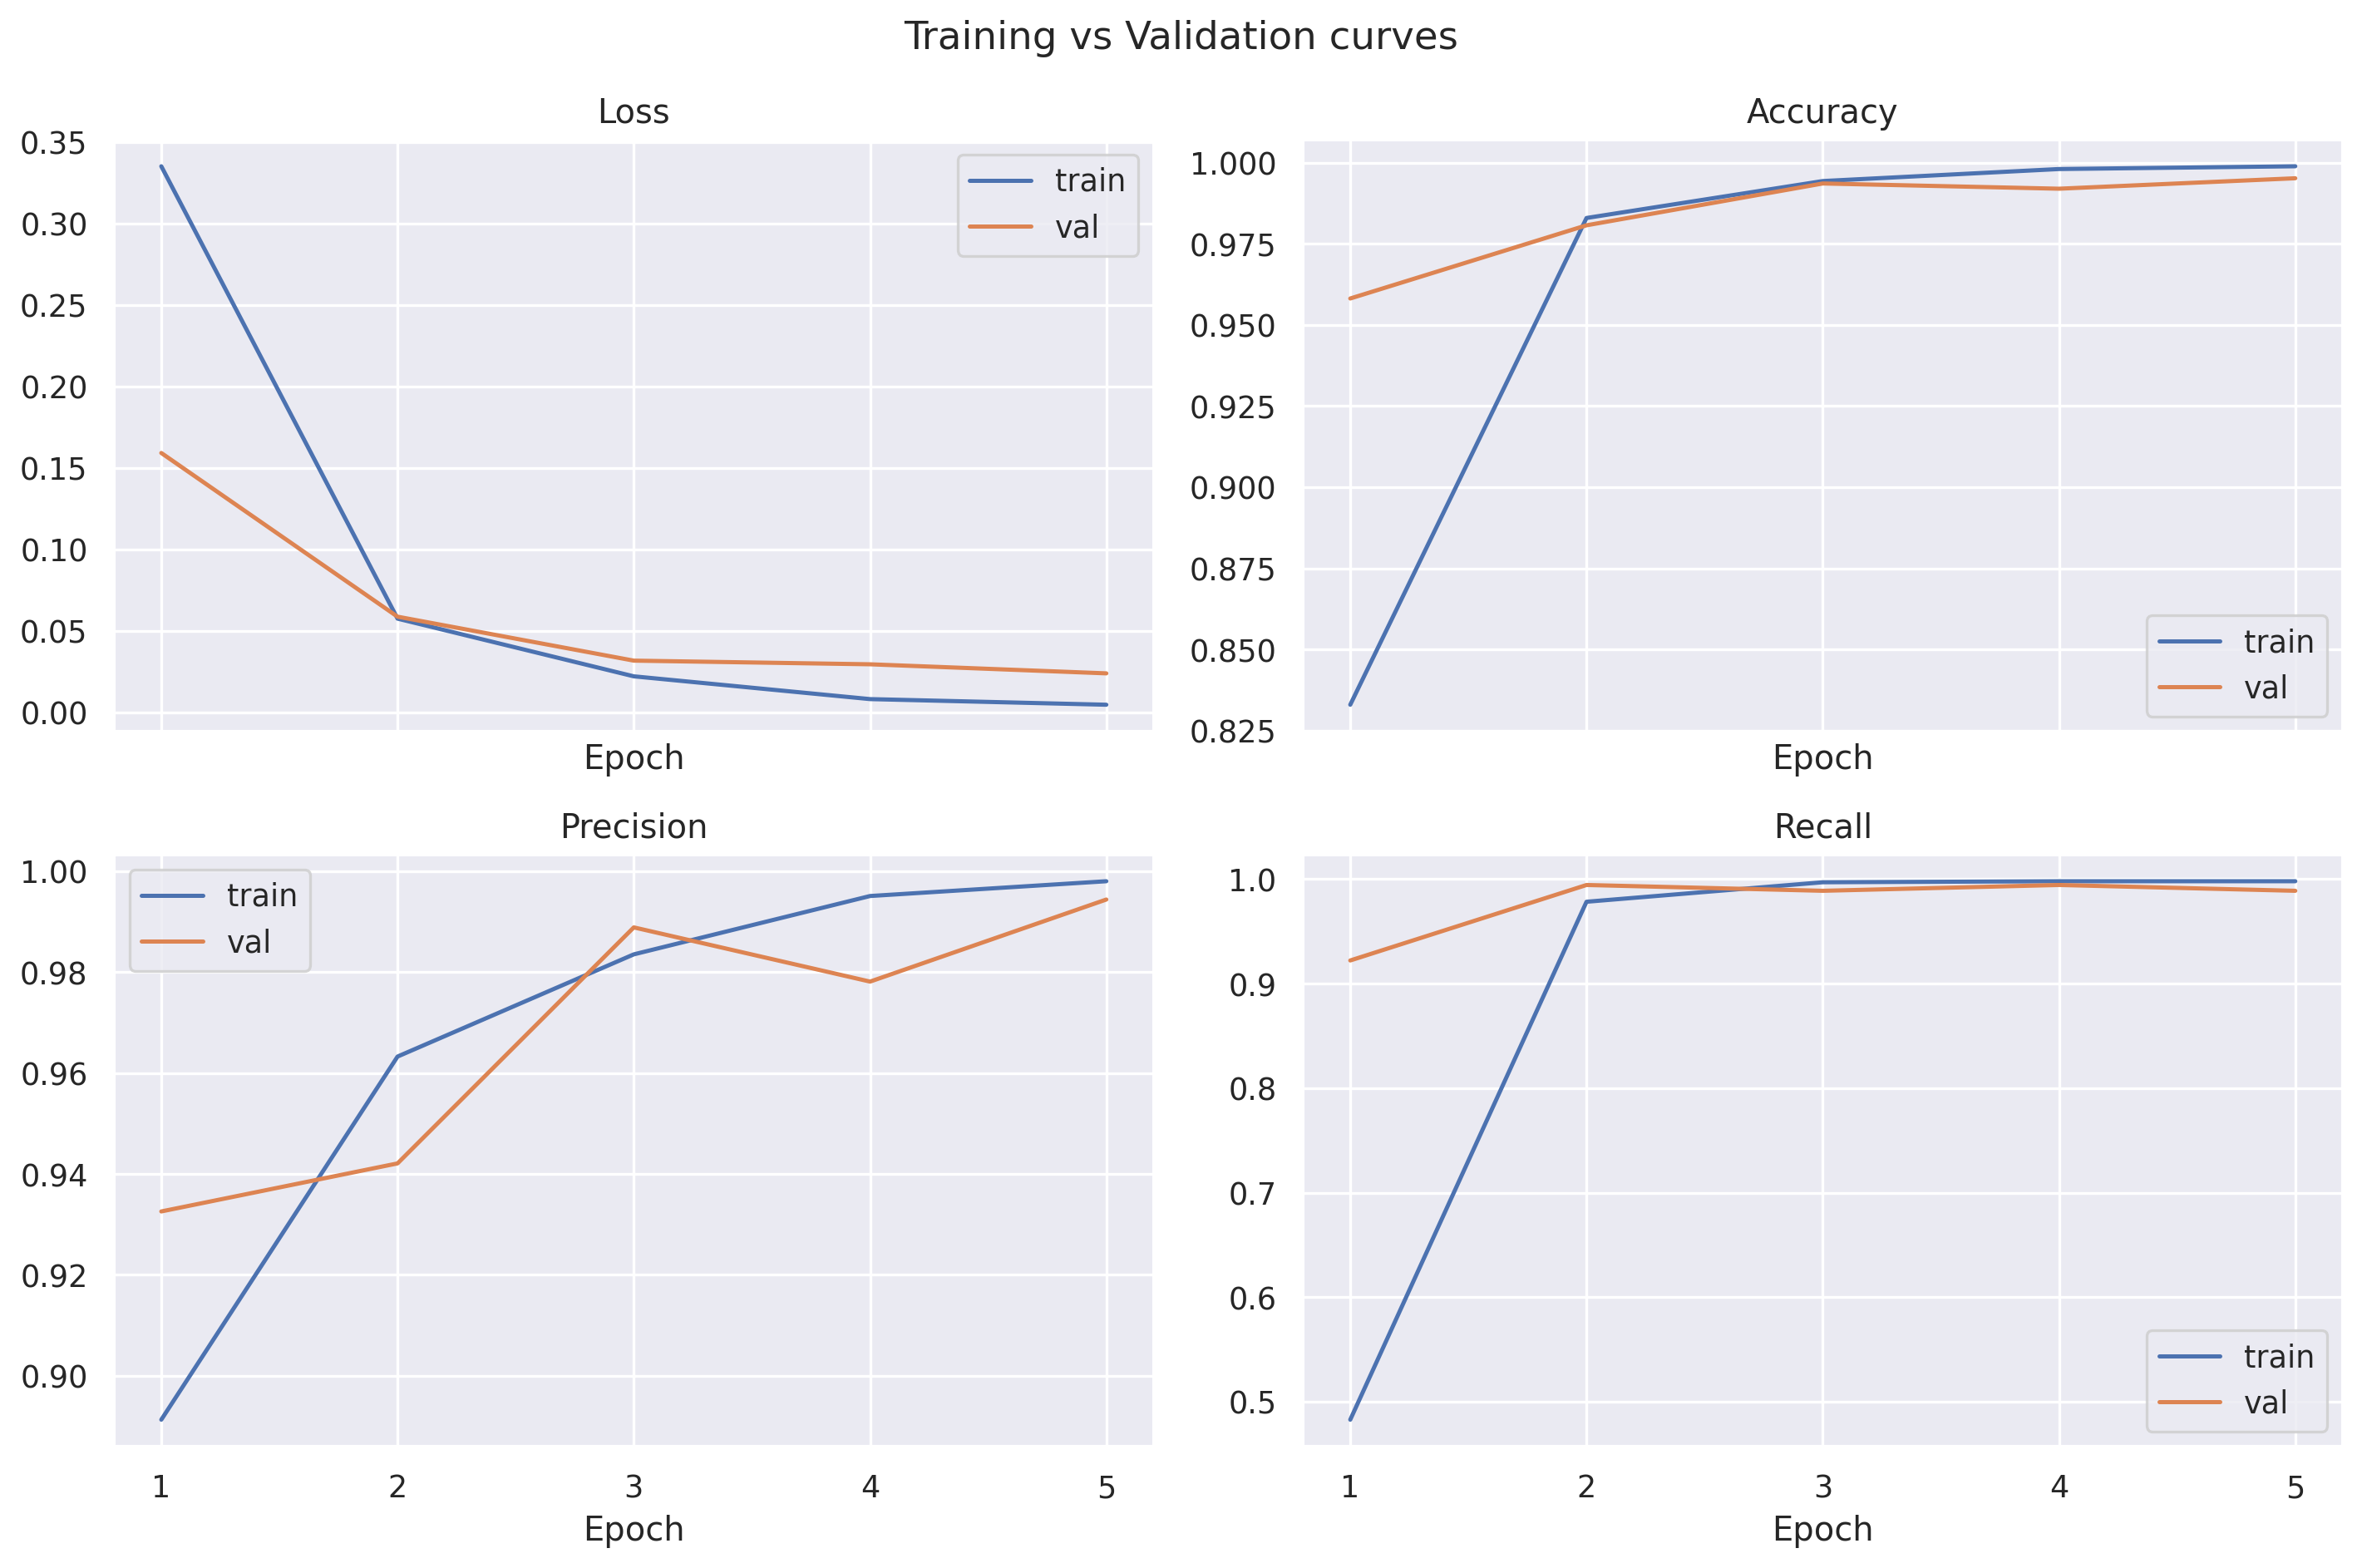

In [ ]:
# Visulization of learning curves for metrics calculated during training

metrics = ['loss', 'accuracy', 'precision', 'recall']

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

for ax, m in zip(axes.flatten(), metrics):
    train_values = history.history.get(m)
    val_values = history.history.get('val_'+m)

    ax.plot(train_values, label='train')
    ax.plot(val_values, label='val')
    ax.set_title(m.capitalize())
    ax.set_xlabel('Epoch')
    ax.legend()

plt.xticks(np.arange(len(train_values)), np.arange(1, len(train_values)+1))
plt.suptitle("Training vs Validation curves", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Save model
RNN_model.save('RNN_model.keras')

In [50]:
# Load model
RNN_model = tf.keras.models.load_model('RNN_model.keras')

In [51]:
# Calculate RNN model metrics on the test set
RNN_res = evaluate_model(model=RNN_model, x_test=X_test_seq, y_test=y_test)

print("Recurrent Neural Network\n")
for metric, value in RNN_res['metrics'].items():
    print(f" {metric+":":<15} {value:<15.4f} ")

Recurrent Neural Network

 accuracy:       0.9816          
 precision:      0.9489          
 recall:         0.9900          
 f1:             0.9690          
 roc_auc:        0.9987          
 pr_auc:         0.9971          


## 4) Classification Model evaluation

In this section, an overall evaluation of the two trained models is performed, by comparing the classification performances obatined on the test set.

In [52]:
all_results = {"Multinomial Naive Bayes": nb_tfidf_bal_res,
               "Recurrent Neural Network": RNN_res,
               }

### Summary of metrics

In [ ]:
# Display summary table
summary_rows = []
for name, res in all_results.items():
    row = {
        "model": name,
        "accuracy": res["metrics"]["accuracy"],
        "precision": res["metrics"]["precision"],
        "recall": res["metrics"]["recall"],
        "f1": res["metrics"]["f1"],
        "roc_auc": res["metrics"]["roc_auc"],
        "pr_auc": res["metrics"]["pr_auc"]
    }
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows).set_index("model").sort_index()
display(summary_df.style.format("{:.4f}"))

,accuracy,precision,recall,f1,roc_auc,pr_auc
model,,,,,,
Multinomial Naive Bayes,0.9710,0.9272,0.9767,0.9513,0.9955,0.9885
Recurrent Neural Network,0.9816,0.9489,0.9900,0.9690,0.9987,0.9971


### Confusion matrices

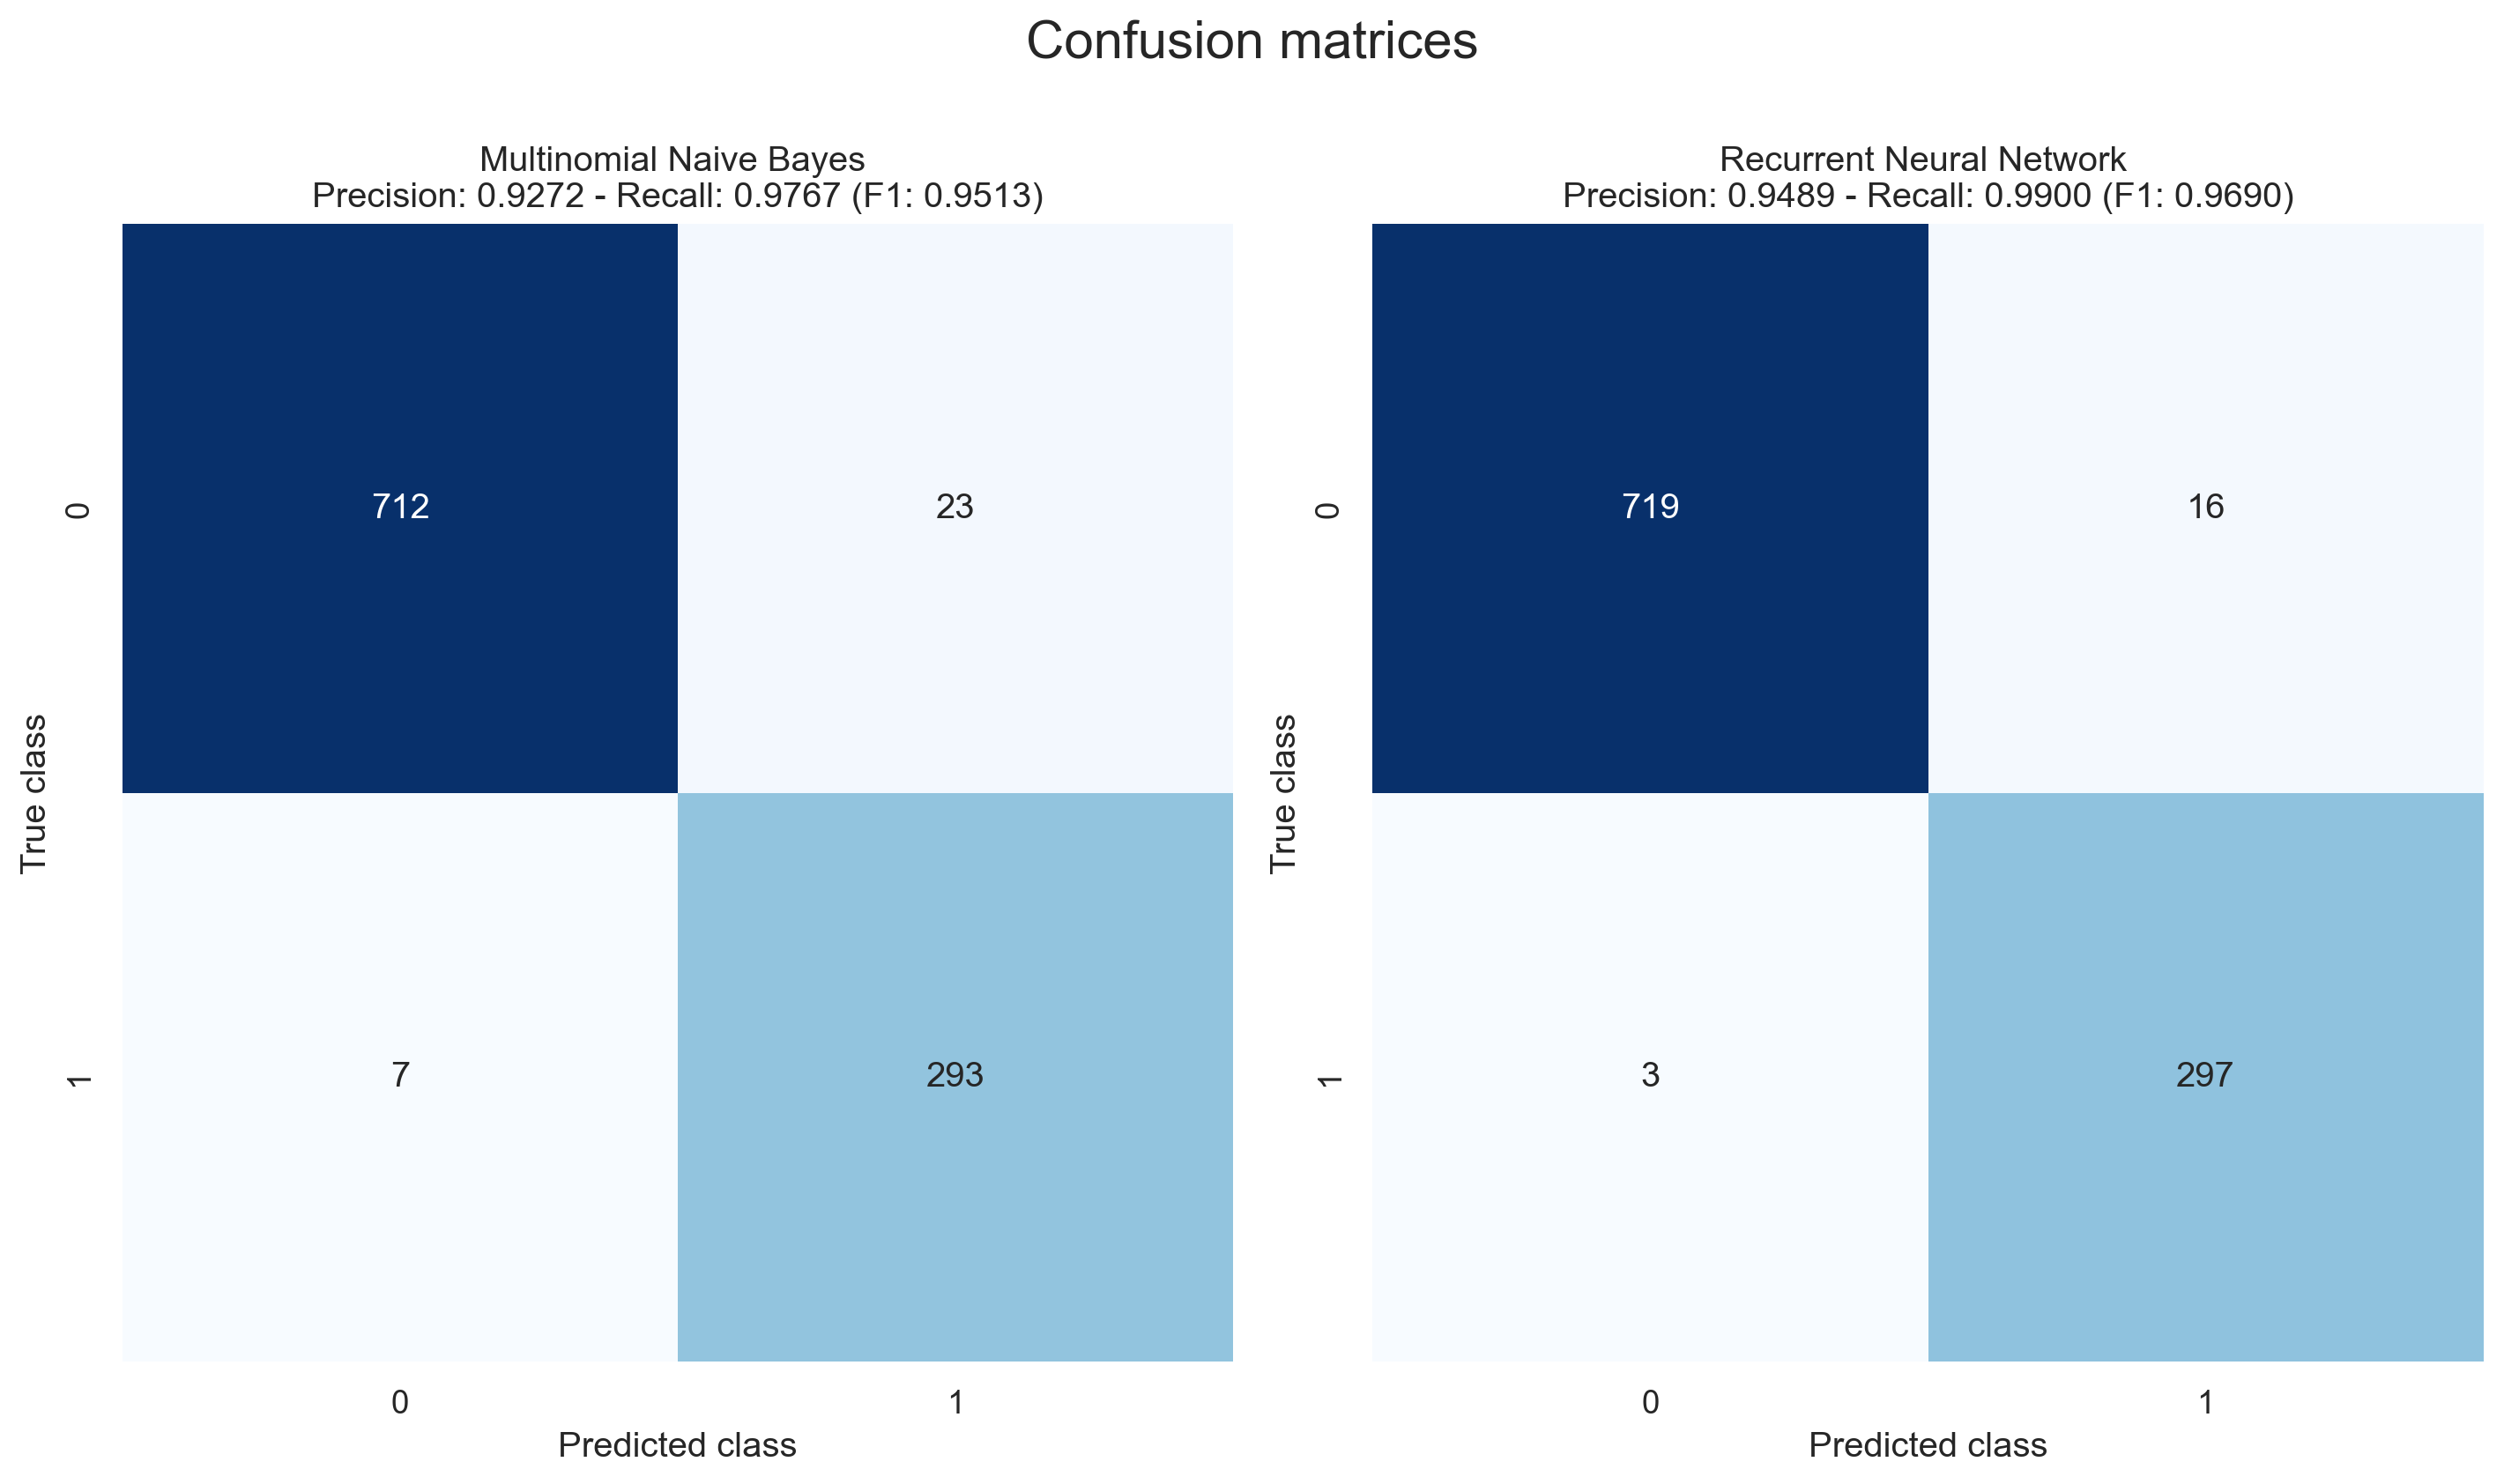

In [ ]:
# Plot confusion matrices from model results
plt.figure(figsize=(12, 7))

for i, (name, result) in enumerate(all_results.items()):

    plt.subplot(1, 2, i+1)
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"""{name} \nPrecision: {result['metrics']['precision']:.4f} - Recall: {result['metrics']['recall']:.4f} (F1: {result['metrics']['f1']:.4f})""")
    plt.xlabel('Predicted class')
    plt.ylabel('True class')

plt.suptitle(f"Confusion matrices", fontsize=18, y=1)
plt.tight_layout()
plt.show()

By observing all metrics and confusion matrices, for a classification threshold of 0.5 (the value used for prediction), both models achieved high classification performances, with all metrics higher than 0.9. The Recurrent Neural Network model obatined slightly better results (with a precision of 0.95 and a recall of 0.99), despite the training dataset was not balanced.

### ROC curves and Precision-Recall curves

Here, the Receiver Operating Characteristic (ROC) curves are calculated and visualized to show the false positive rate versus the true positive rate for different classification thresholds values between 0.0 and 1.0.

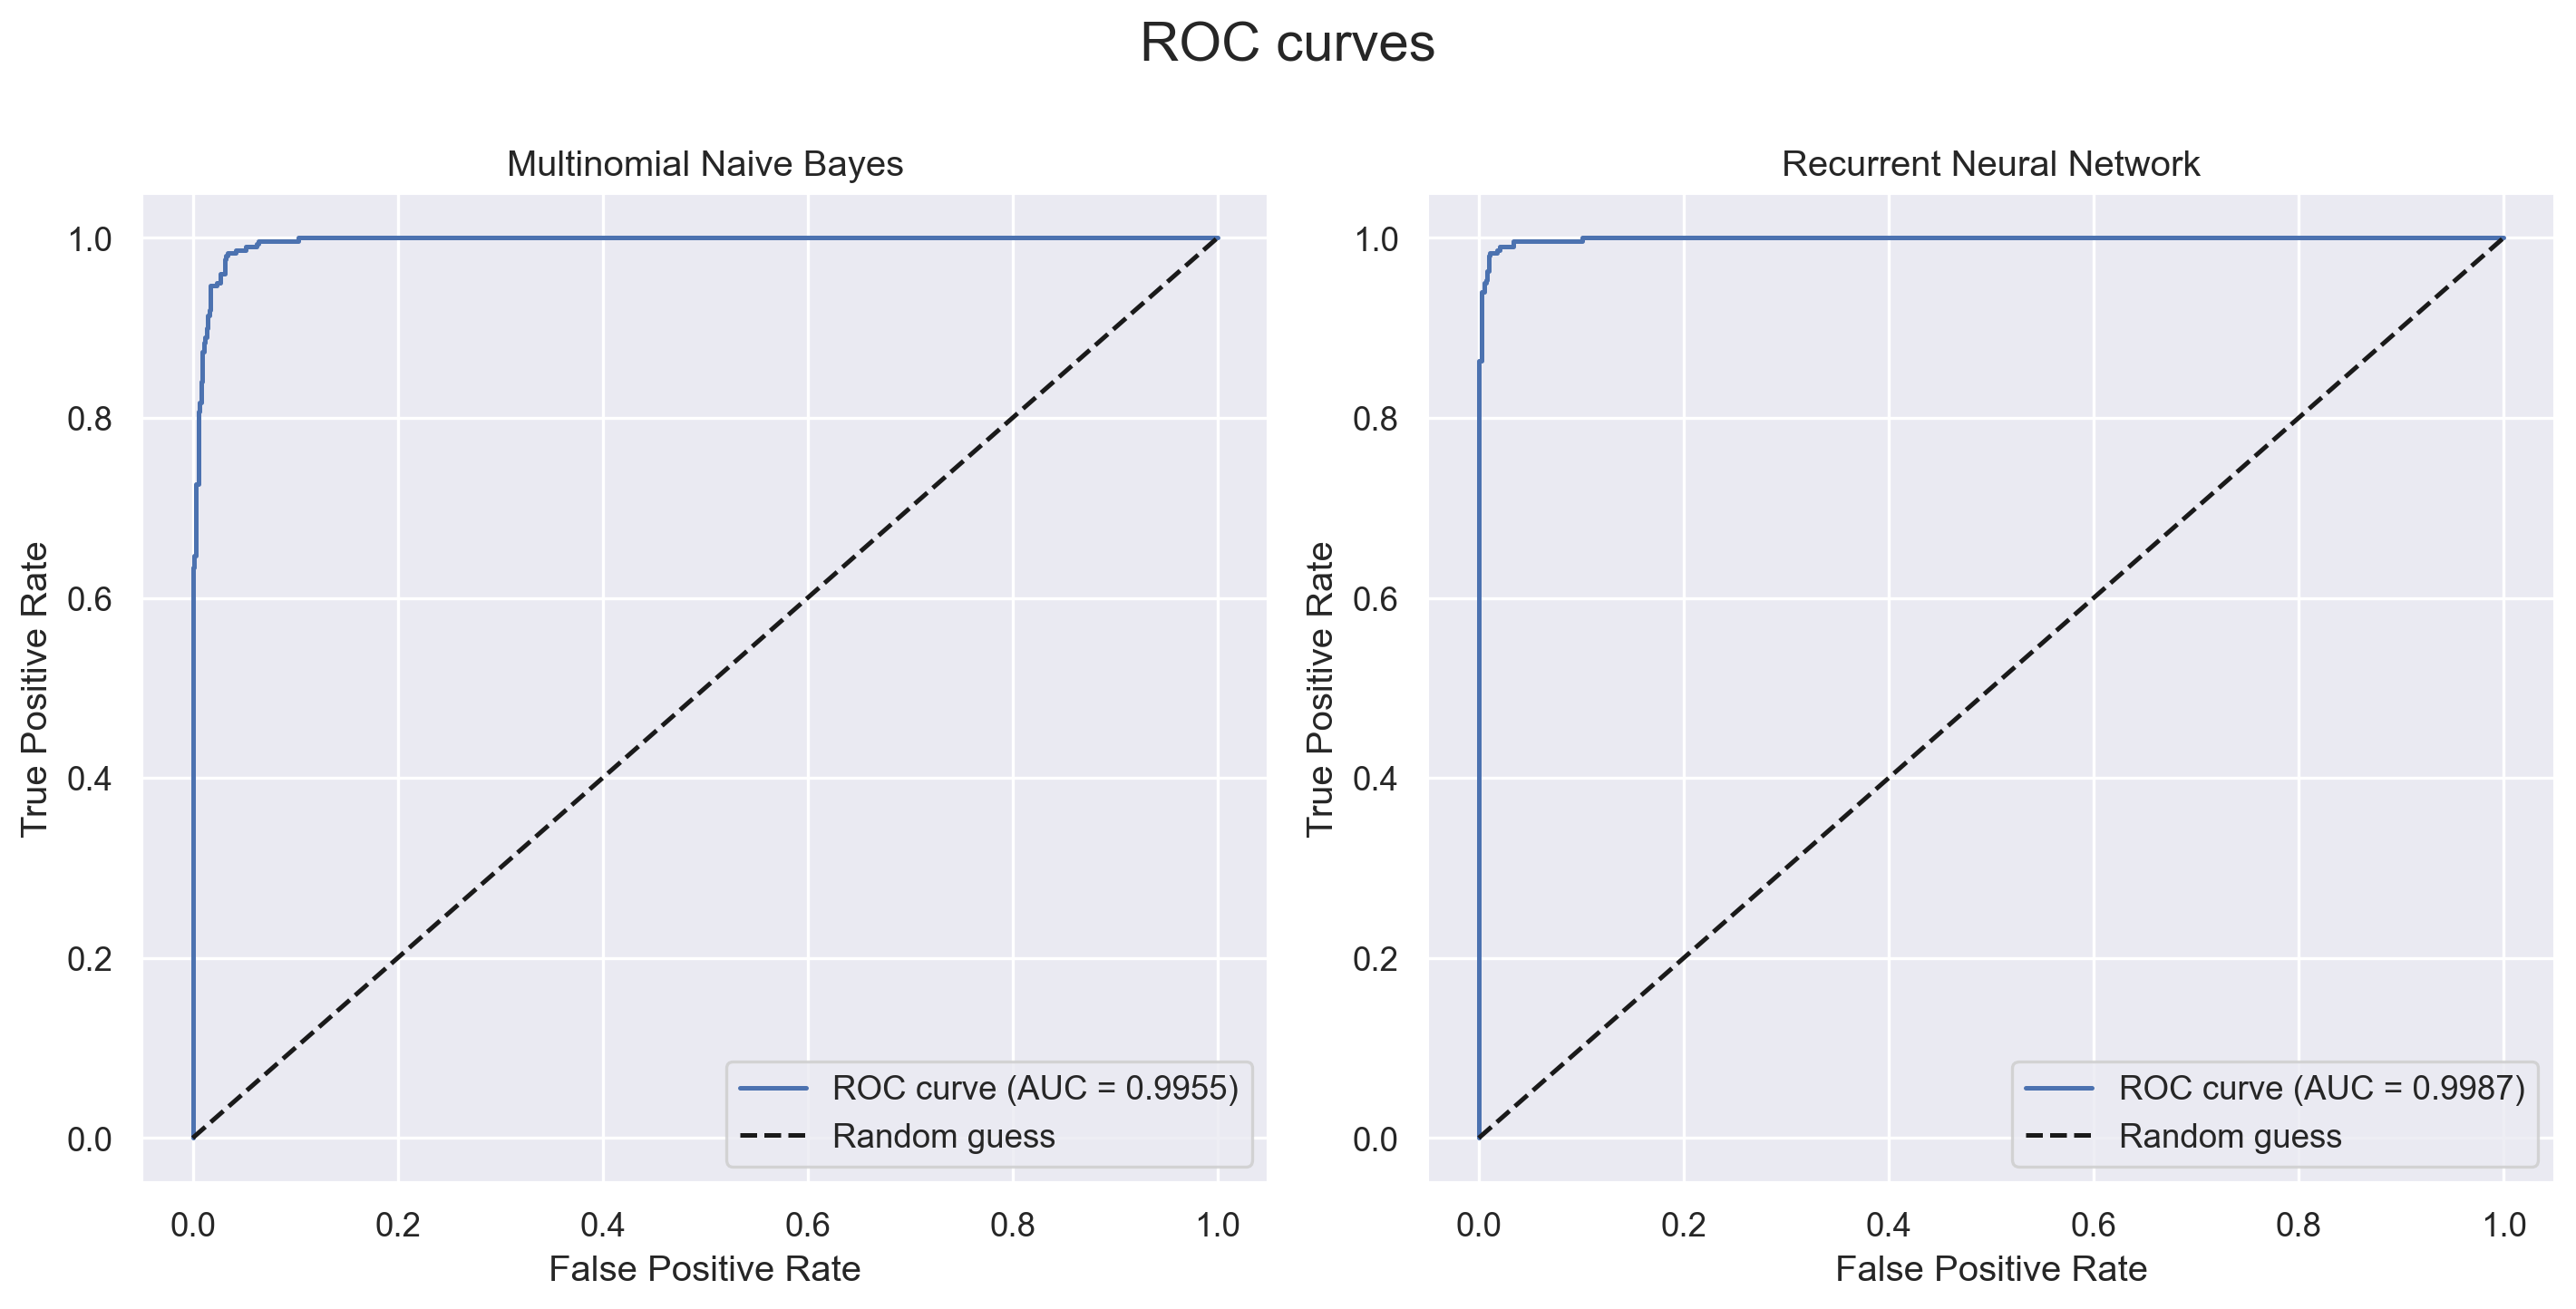

In [ ]:
# Plot ROC curves from model results
plt.figure(figsize=(12, 6))

for i, (name, result) in enumerate(all_results.items()):

    plt.subplot(1, 2, i+1)

    fpr, tpr, _ = roc_curve(y_test, result["predictions"])
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {result["metrics"]['roc_auc']:.4f})")

    plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"{name}")
    plt.legend(loc='lower right')
    plt.grid(True)

plt.suptitle(f"ROC curves", fontsize=18, y=1)
plt.tight_layout()
plt.show()

In this case, the areas under the curve (AUC), representing a summary of the model skills, are higher than 0.99 for both models.

Lastly, The precision-recall curves, which plot the precision and the recall values for different classification thresholds, are also calculated and visualized.

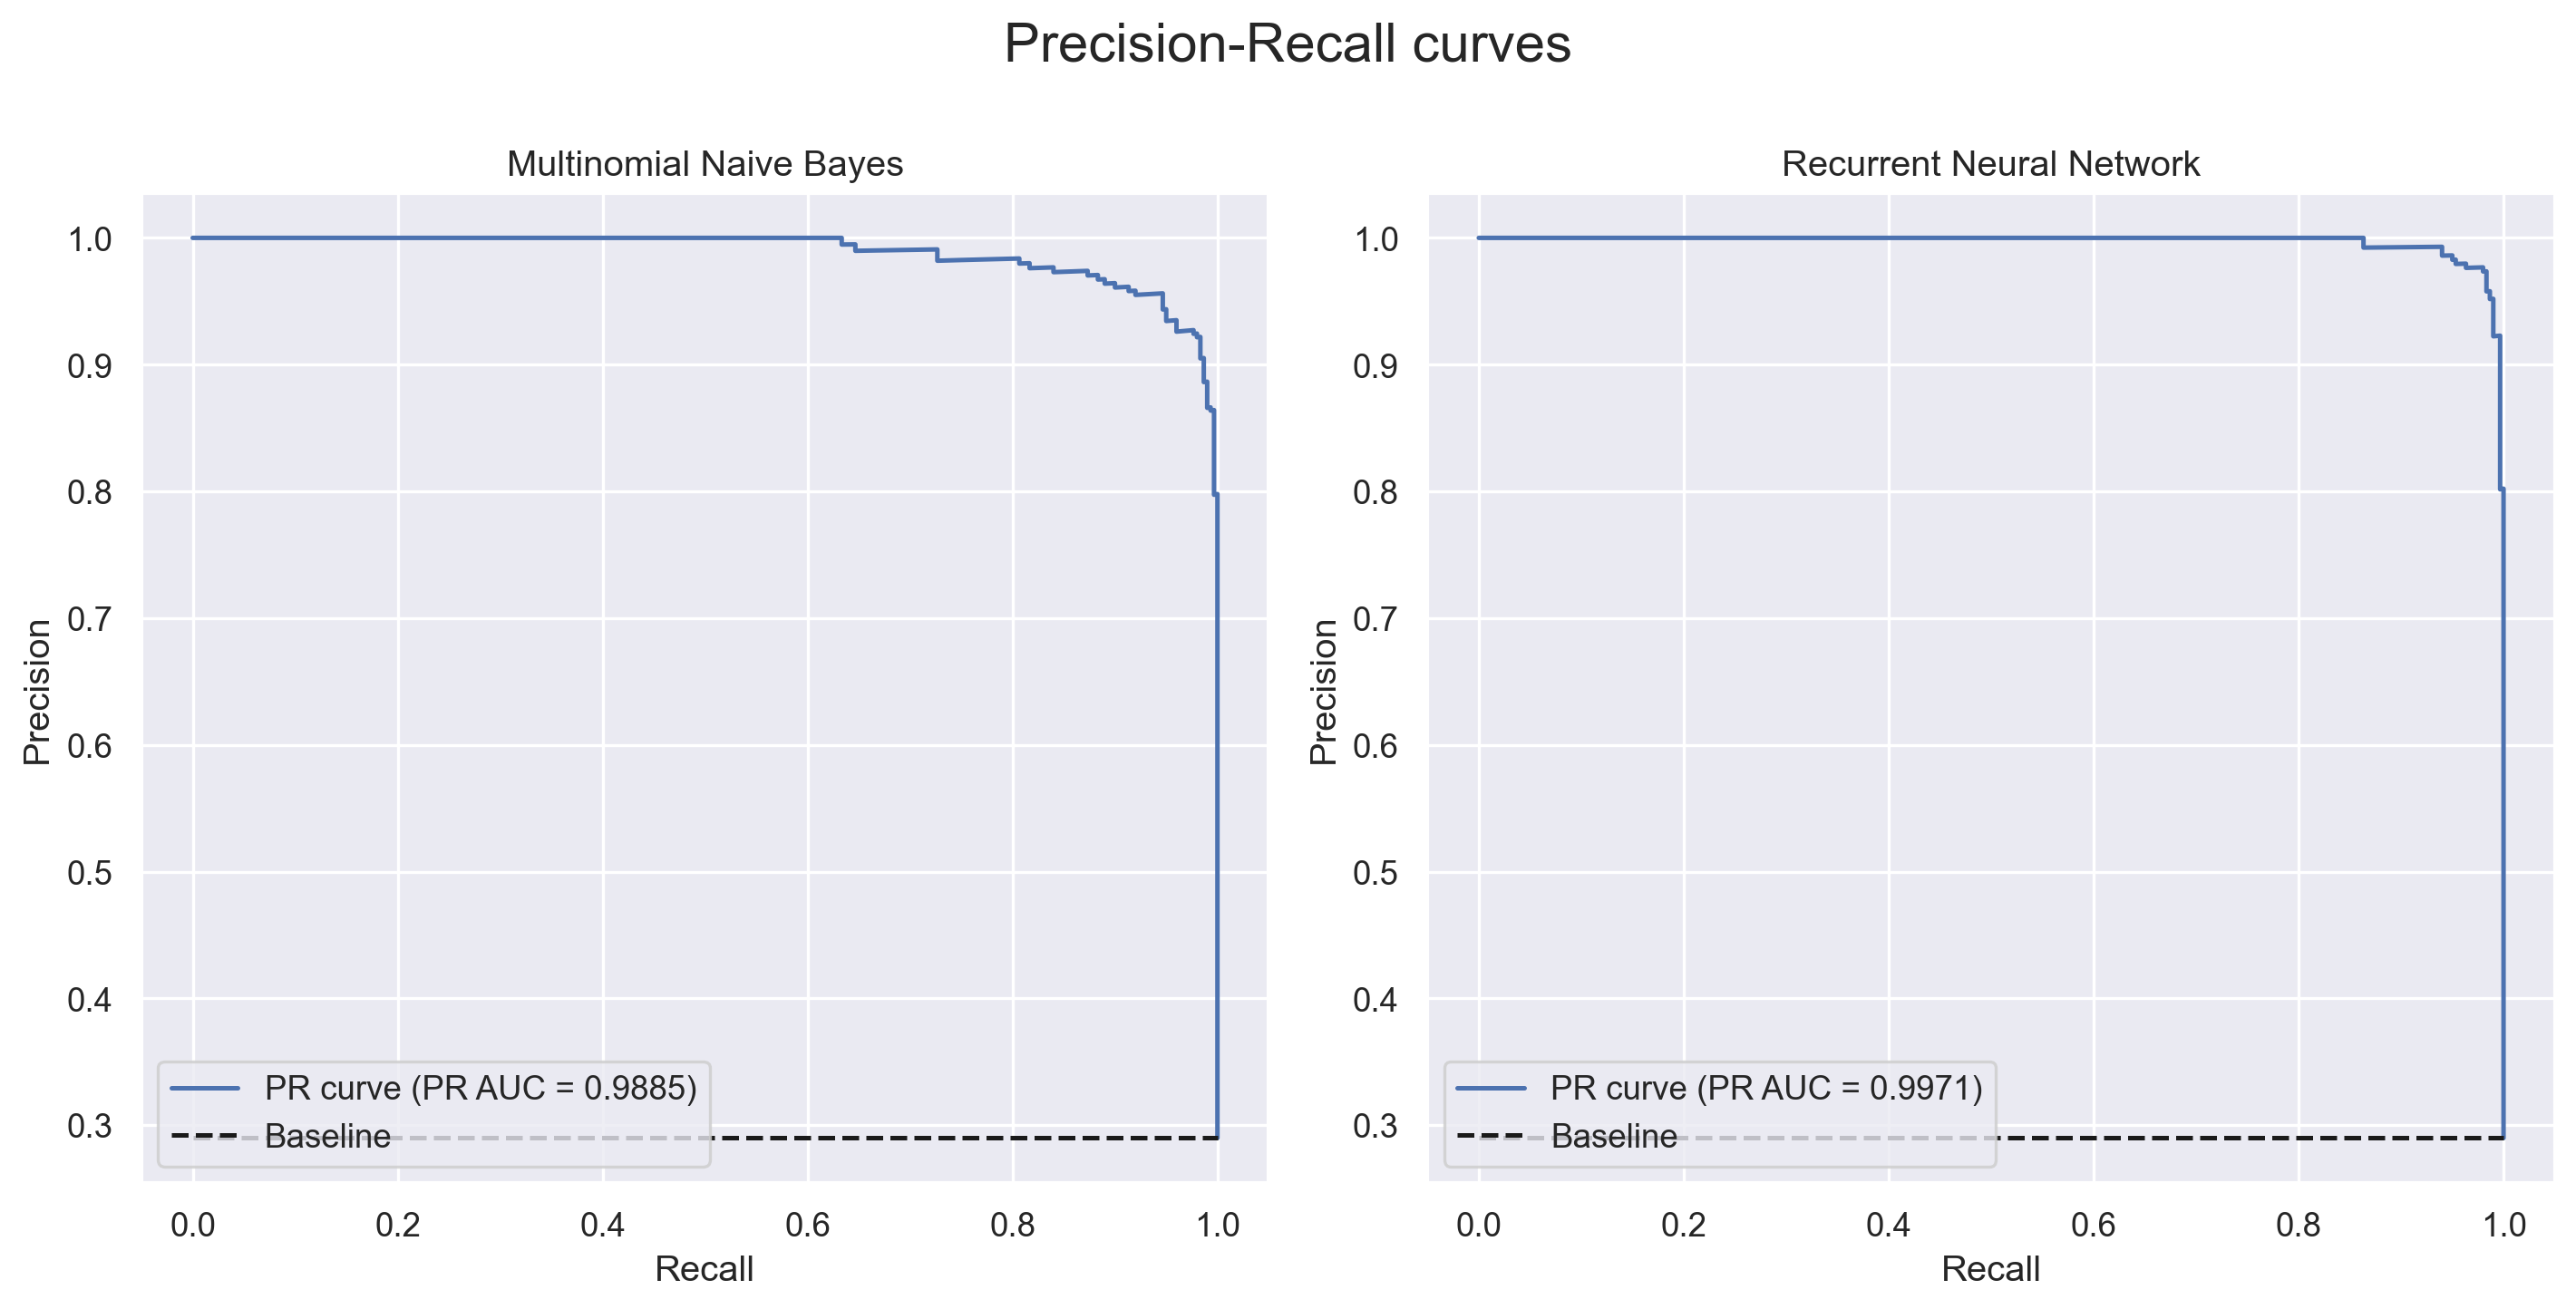

In [ ]:
# Plot Precision-Recall curves from model results

plt.figure(figsize=(12, 6))

for i, (name, result) in enumerate(all_results.items()):

    plt.subplot(1, 2, i+1)

    precision, recall, _ = precision_recall_curve(y_test, result["predictions"])
    plt.plot(recall, precision, label=f"PR curve (PR AUC = {result["metrics"]['pr_auc']:.4f})")

    plt.plot([0, 1], [sum(y_test)/len(y_test)]*2, 'k--', label='Baseline')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f"{name}")
    plt.legend(loc='lower left')
    plt.grid(True)

plt.suptitle(f"Precision-Recall curves", fontsize=18, y=1)
plt.tight_layout()
plt.show()

It can be observed that the AUC values in the Precision-Recall curves are also near or higher than 0.99. This equality between ROC AUC and Precision-Recall AUC indicates that data imbalance did not affect the model classification performances.

## 5) Topic modelling

In this section, a method to identify the main topics among the emails classified as SPAM will be applied, using the [Latent Dirichlet Allocation](https://radimrehurek.com/gensim/models/ldamulticore.html) (LDA) model implemented in Gensim. LDA is a widely applied topic modeling method based on a conditional, probabilistic approach. This method applies unsupervised learning on text datasets in order to produce a summary set of terms derived from those documents, which represents their overall primary set of topics.

In [53]:
# Add predicted SPAM columns from models to the dataframe

# Multinomial NB
X_all_tfidf = tfidf.transform(df['clean_text'])
df["pred_nb"] = nb_tfidf_bal.predict(X_all_tfidf)

# RNN model
all_seq = vectorizer(df['clean_text']).numpy()
proba = RNN_model.predict(all_seq, batch_size=256, verbose=0)
df["pred_rnn"]  = (proba >= 0.5).astype(int)

In [54]:
# Get a DataFrame containing only spam emails according to a source:
# - "label_num" (true spam emails)
# - "pred_nb" (Naive Bayes predictions)
# - "pred_rnn" (RNN predictions)

SOURCE = "label_num"
spam_df = df[df[SOURCE]==1].reset_index()

In [55]:
# Build dictionary and corpus from the spam emails dataframe
token_lists = spam_df["tokens"].tolist()
dictionary = corpora.Dictionary(token_lists)
corpus = [dictionary.doc2bow(tokens) for tokens in token_lists]

In [56]:
# Build LDA model
lda_model = LdaMulticore(corpus=corpus,
                         id2word=dictionary,
                         num_topics=8,
                         passes=5)

Here, top words and their weights for each detected topic are displayed.

In [57]:
lda_model.print_topics()

[(0,
  '0.004*"subject" + 0.004*"gas" + 0.003*"company" + 0.003*"account" + 0.003*"may" + 0.002*"com" + 0.002*"wysak" + 0.002*"oil" + 0.002*"within" + 0.002*"http"'),
 (1,
  '0.009*"subject" + 0.003*"free" + 0.002*"back" + 0.002*"get" + 0.002*"please" + 0.002*"http" + 0.002*"click" + 0.002*"new" + 0.001*"com" + 0.001*"time"'),
 (2,
  '0.012*"subject" + 0.005*"windows" + 0.005*"adobe" + 0.005*"soft" + 0.005*"http" + 0.004*"cialis" + 0.004*"office" + 0.004*"xp" + 0.004*"microsoft" + 0.003*"price"'),
 (3,
  '0.006*"subject" + 0.004*"said" + 0.003*"one" + 0.002*"rnd" + 0.002*"information" + 0.002*"sources" + 0.002*"http" + 0.002*"com" + 0.002*"company" + 0.002*"alt"'),
 (4,
  '0.014*"com" + 0.011*"subject" + 0.010*"www" + 0.009*"http" + 0.007*"computron" + 0.005*"message" + 0.005*"contact" + 0.005*"please" + 0.005*"us" + 0.004*"mail"'),
 (5,
  '0.008*"company" + 0.007*"subject" + 0.007*"statements" + 0.006*"nbsp" + 0.005*"pills" + 0.005*"information" + 0.005*"may" + 0.004*"investment" + 0.

Here, a method to calculate and assign the dominant topic of each SPAM email in the dataset is implemeted.

In [58]:
# Define a function to calculate the index and score of the dominant topic for a document

def get_dominant_topic(doc):

    doc_lda = lda_model.get_document_topics(dictionary.doc2bow(doc), minimum_probability=0.0)
    doc_topic_scores = np.vstack([topic[1] for topic in doc_lda])
    dominant_topic_idx = doc_topic_scores.argmax()
    dominant_topic_score = doc_topic_scores[dominant_topic_idx][0]

    return dominant_topic_idx, dominant_topic_score

In [59]:
# Apply the function to the spam email dataframe to get dominant topic index and score columns
spam_df['dom_topic_idx'], spam_df['dom_topic_score'] = zip(*spam_df['tokens'].map(get_dominant_topic))

In [60]:
spam_df[['clean_text','dom_topic_idx','dom_topic_score']].head()

,clean_text,dom_topic_idx,dom_topic_score
0,subject photoshop windows office cheap main tr...,3,0.925875
1,subject looking medication best source difficu...,5,0.544105
2,subject vocable rnd word asceticism vcsc brand...,5,0.998594
3,subject report wffur attion brom est inst siup...,1,0.978065
4,subject vic odin ow berne hotbox carnal bride ...,7,0.981688


In [61]:
# Topic sizes
topic_sizes = pd.Series(spam_df["dom_topic_idx"]).value_counts().sort_index()
print("Topic sizes (#docs per dominant topic):")
print(topic_sizes)

Topic sizes (#docs per dominant topic):
dom_topic_idx
0     60
1    109
2    261
3    117
4    275
5    381
6     82
7    214
Name: count, dtype: int64


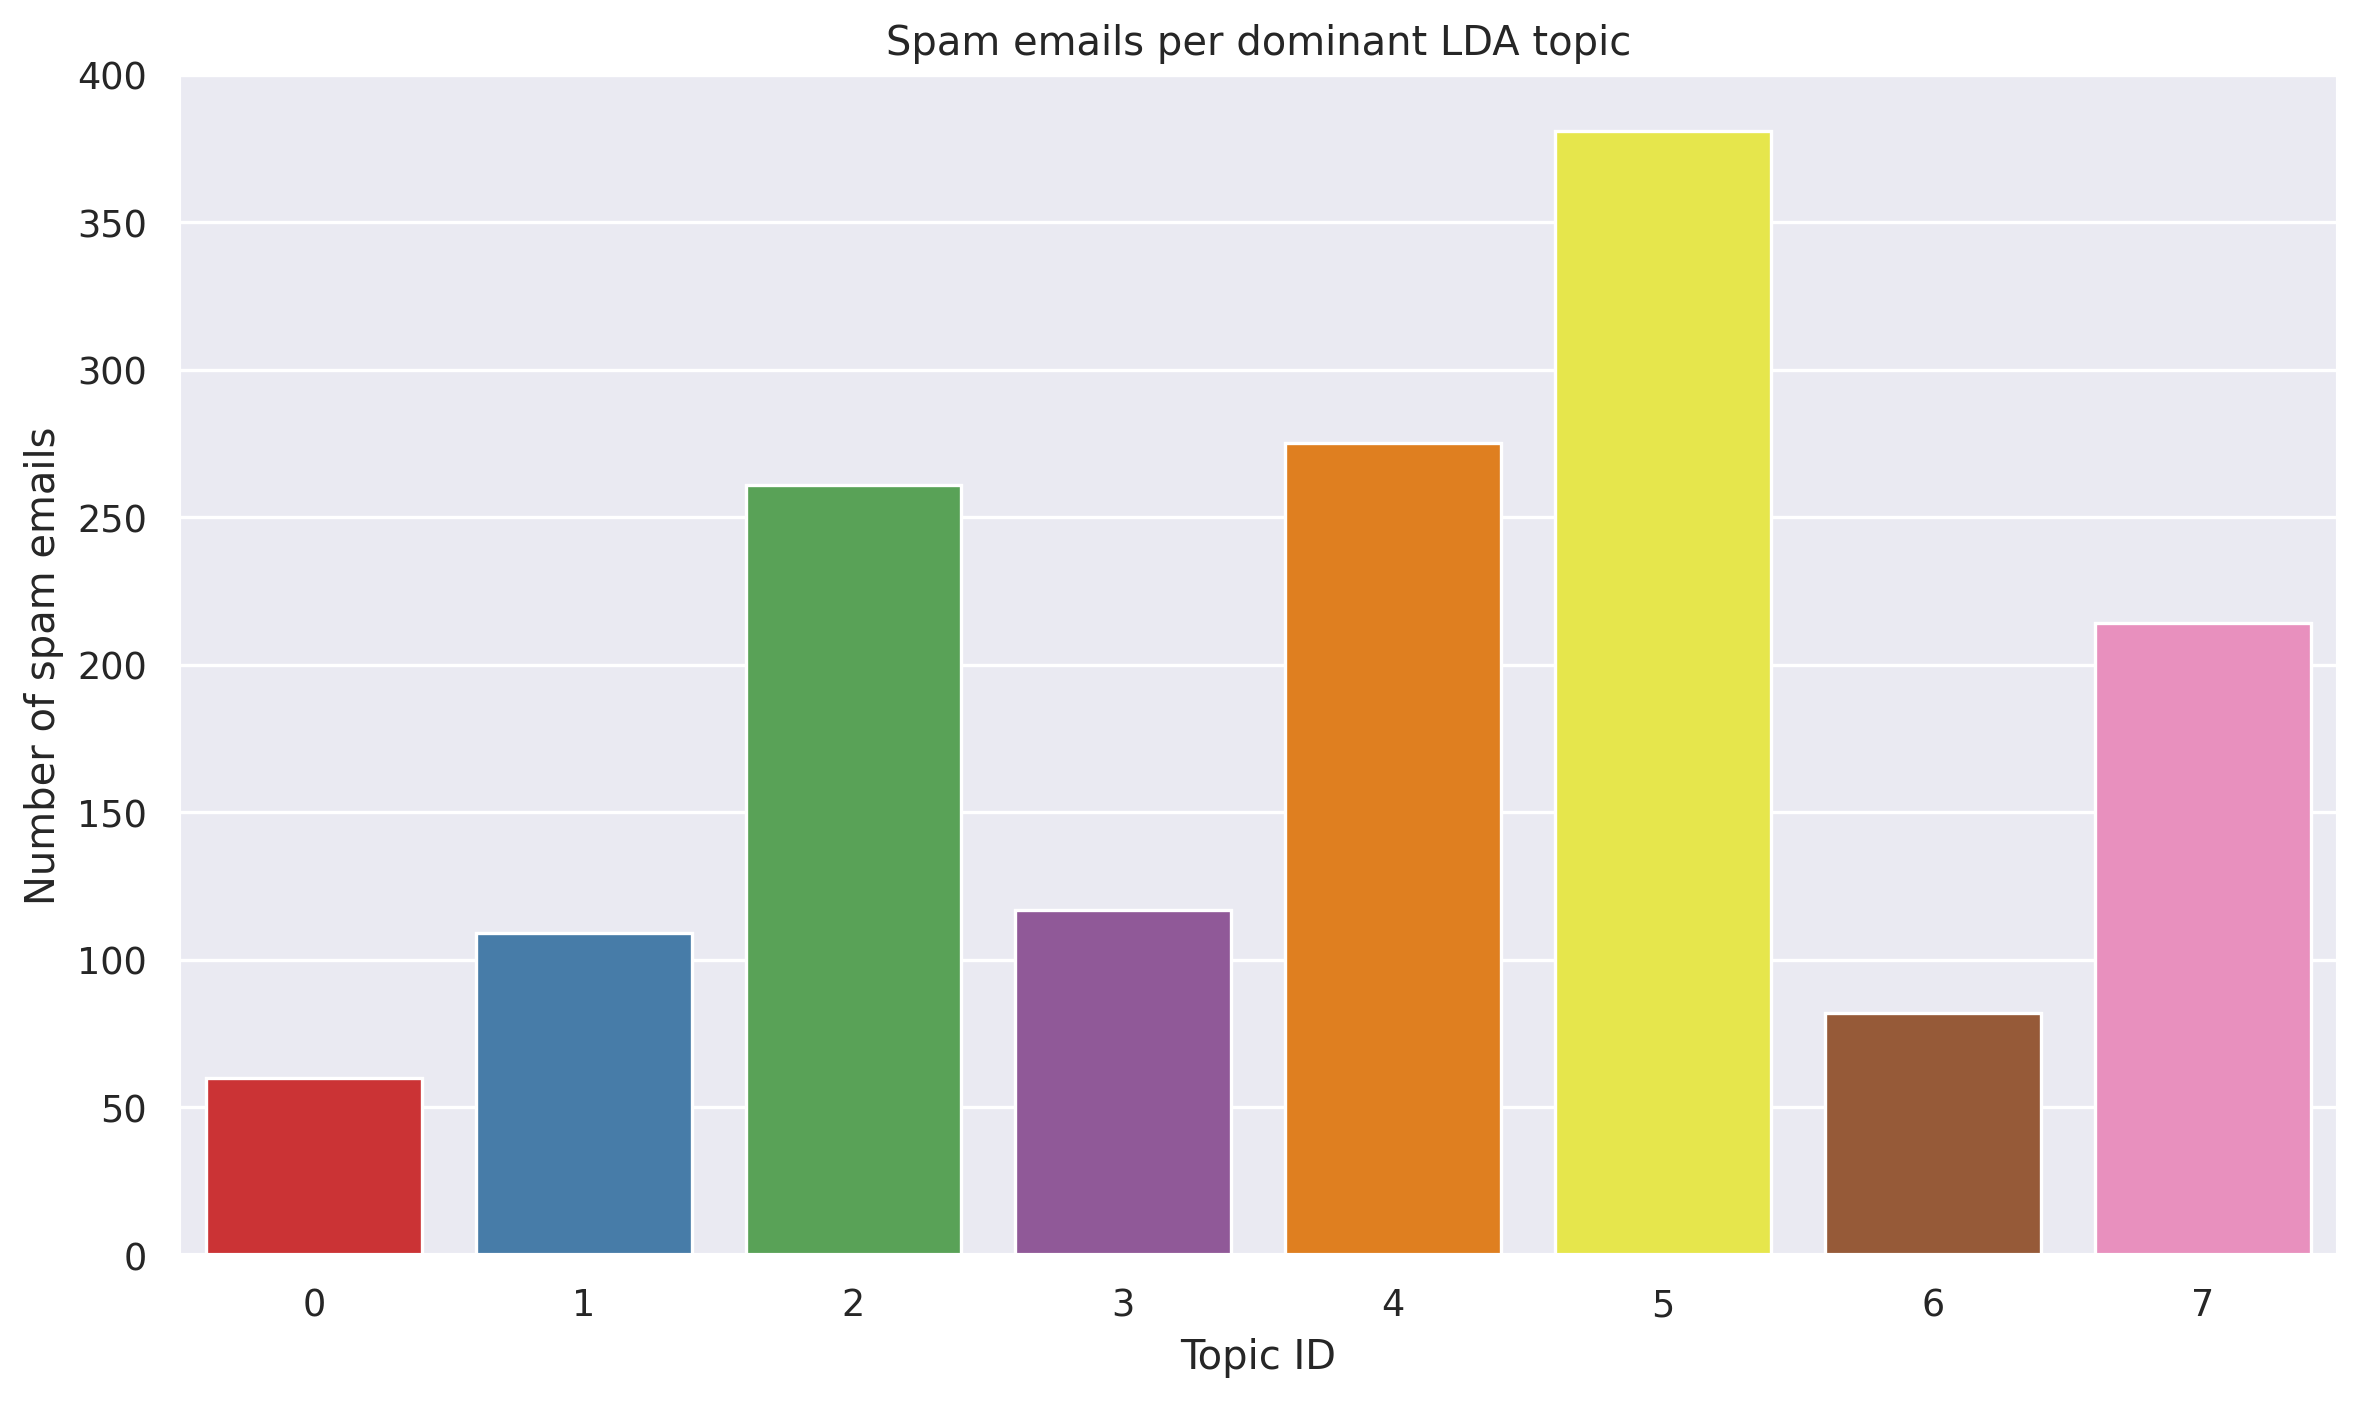

In [62]:
# Plot topic sizes
plt.figure(figsize=(10,6))
sns.barplot(x=topic_sizes.index.astype(str), y=topic_sizes.values, hue=topic_sizes.index.astype(str), palette="Set1")
plt.xlabel("Topic ID")
plt.ylabel("Number of spam emails")
plt.title("Spam emails per dominant LDA topic")
plt.tight_layout()
plt.show()

## 6) Topic similarity

In this section, a method to find the **semantic distances** among obtained topics of SPAM emails will be implemented, calculating the *cosine similarity*, a measure of similarity between two non-zero vectors, defined as the cosine of the angle between them.

First, vector embeddings of emails of the different topics will be obtained using the [Doc2Vec](https://radimrehurek.com/gensim/models/doc2vec.html) algorithm implemented in Gensim, which produces vector representations for entire documents or group of words.

Then, the *cosine similarity* between all topics will be derived from the [*cosine distance*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html), calculated using the scipy library.

In [63]:
# Define a function to associate a tag/number with each document of the training corpus
def tagged_document(documents):
  for i, doc in enumerate(documents):
    yield doc2vec.TaggedDocument(doc, [i])

In [64]:
# Define the training data
spam_emails_list = spam_df["tokens"].to_list()
train_data = list(tagged_document(spam_emails_list))

In [65]:
# Initialize the model
d2v_model = doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)

# Build the vocabulary
d2v_model.build_vocab(train_data)

# Train the Doc2Vec model
d2v_model.train(train_data, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

In [66]:
topics = lda_model.get_topics()

# Define a cosine similarity matrix
sim_matrix  = np.zeros((len(topics), len(topics)), dtype=float)

for i, ti in enumerate(topics):
    for j, tj in enumerate(topics):

        if i == j:
            similarity = 1.0

        else:
            # First topic
            words_list_i = spam_df[spam_df["dom_topic_idx"]==i]["tokens"].values.tolist()
            words_list_i_flat = []
            for row in words_list_i:
                words_list_i_flat.extend(row)
            vector_i = d2v_model.infer_vector(words_list_i_flat)
            # Second topic
            words_list_j = spam_df[spam_df["dom_topic_idx"]==j]["tokens"].values.tolist()
            words_list_j_flat = []
            for row in words_list_j:
                words_list_j_flat.extend(row)
            vector_j = d2v_model.infer_vector(words_list_j_flat)
            # Calculate cosine similarity as 1 - cosine distance
            similarity = 1.0 - cosine(vector_i, vector_j)

        # Add to cosine similarity matrix
        sim_matrix[i, j]  = similarity

In [67]:
# Create a dataframe from the cosine similarity matrix
sim_df  = pd.DataFrame(sim_matrix,  index=[f"T_{i}" for i, t in enumerate(topics)], columns=[f"T_{i}" for i, t in enumerate(topics)])

print("Cosine similarity between topics:")
display(sim_df.round(3))

Cosine similarity between topics:


,T_0,T_1,T_2,T_3,T_4,T_5,T_6,T_7
T_0,1.000,0.186,0.204,0.411,0.135,0.084,0.189,0.256
T_1,0.209,1.000,0.550,0.391,0.169,-0.198,0.431,0.479
T_2,0.184,0.559,1.000,0.315,0.183,-0.150,0.301,0.378
T_3,0.406,0.444,0.309,1.000,0.040,-0.051,0.263,0.278
T_4,0.116,0.169,0.175,0.053,1.000,0.266,0.113,-0.069
T_5,0.124,-0.205,-0.149,-0.055,0.282,1.000,-0.170,-0.217
T_6,0.167,0.440,0.296,0.264,0.117,-0.164,1.000,0.106
T_7,0.254,0.466,0.358,0.274,-0.088,-0.198,0.102,1.000


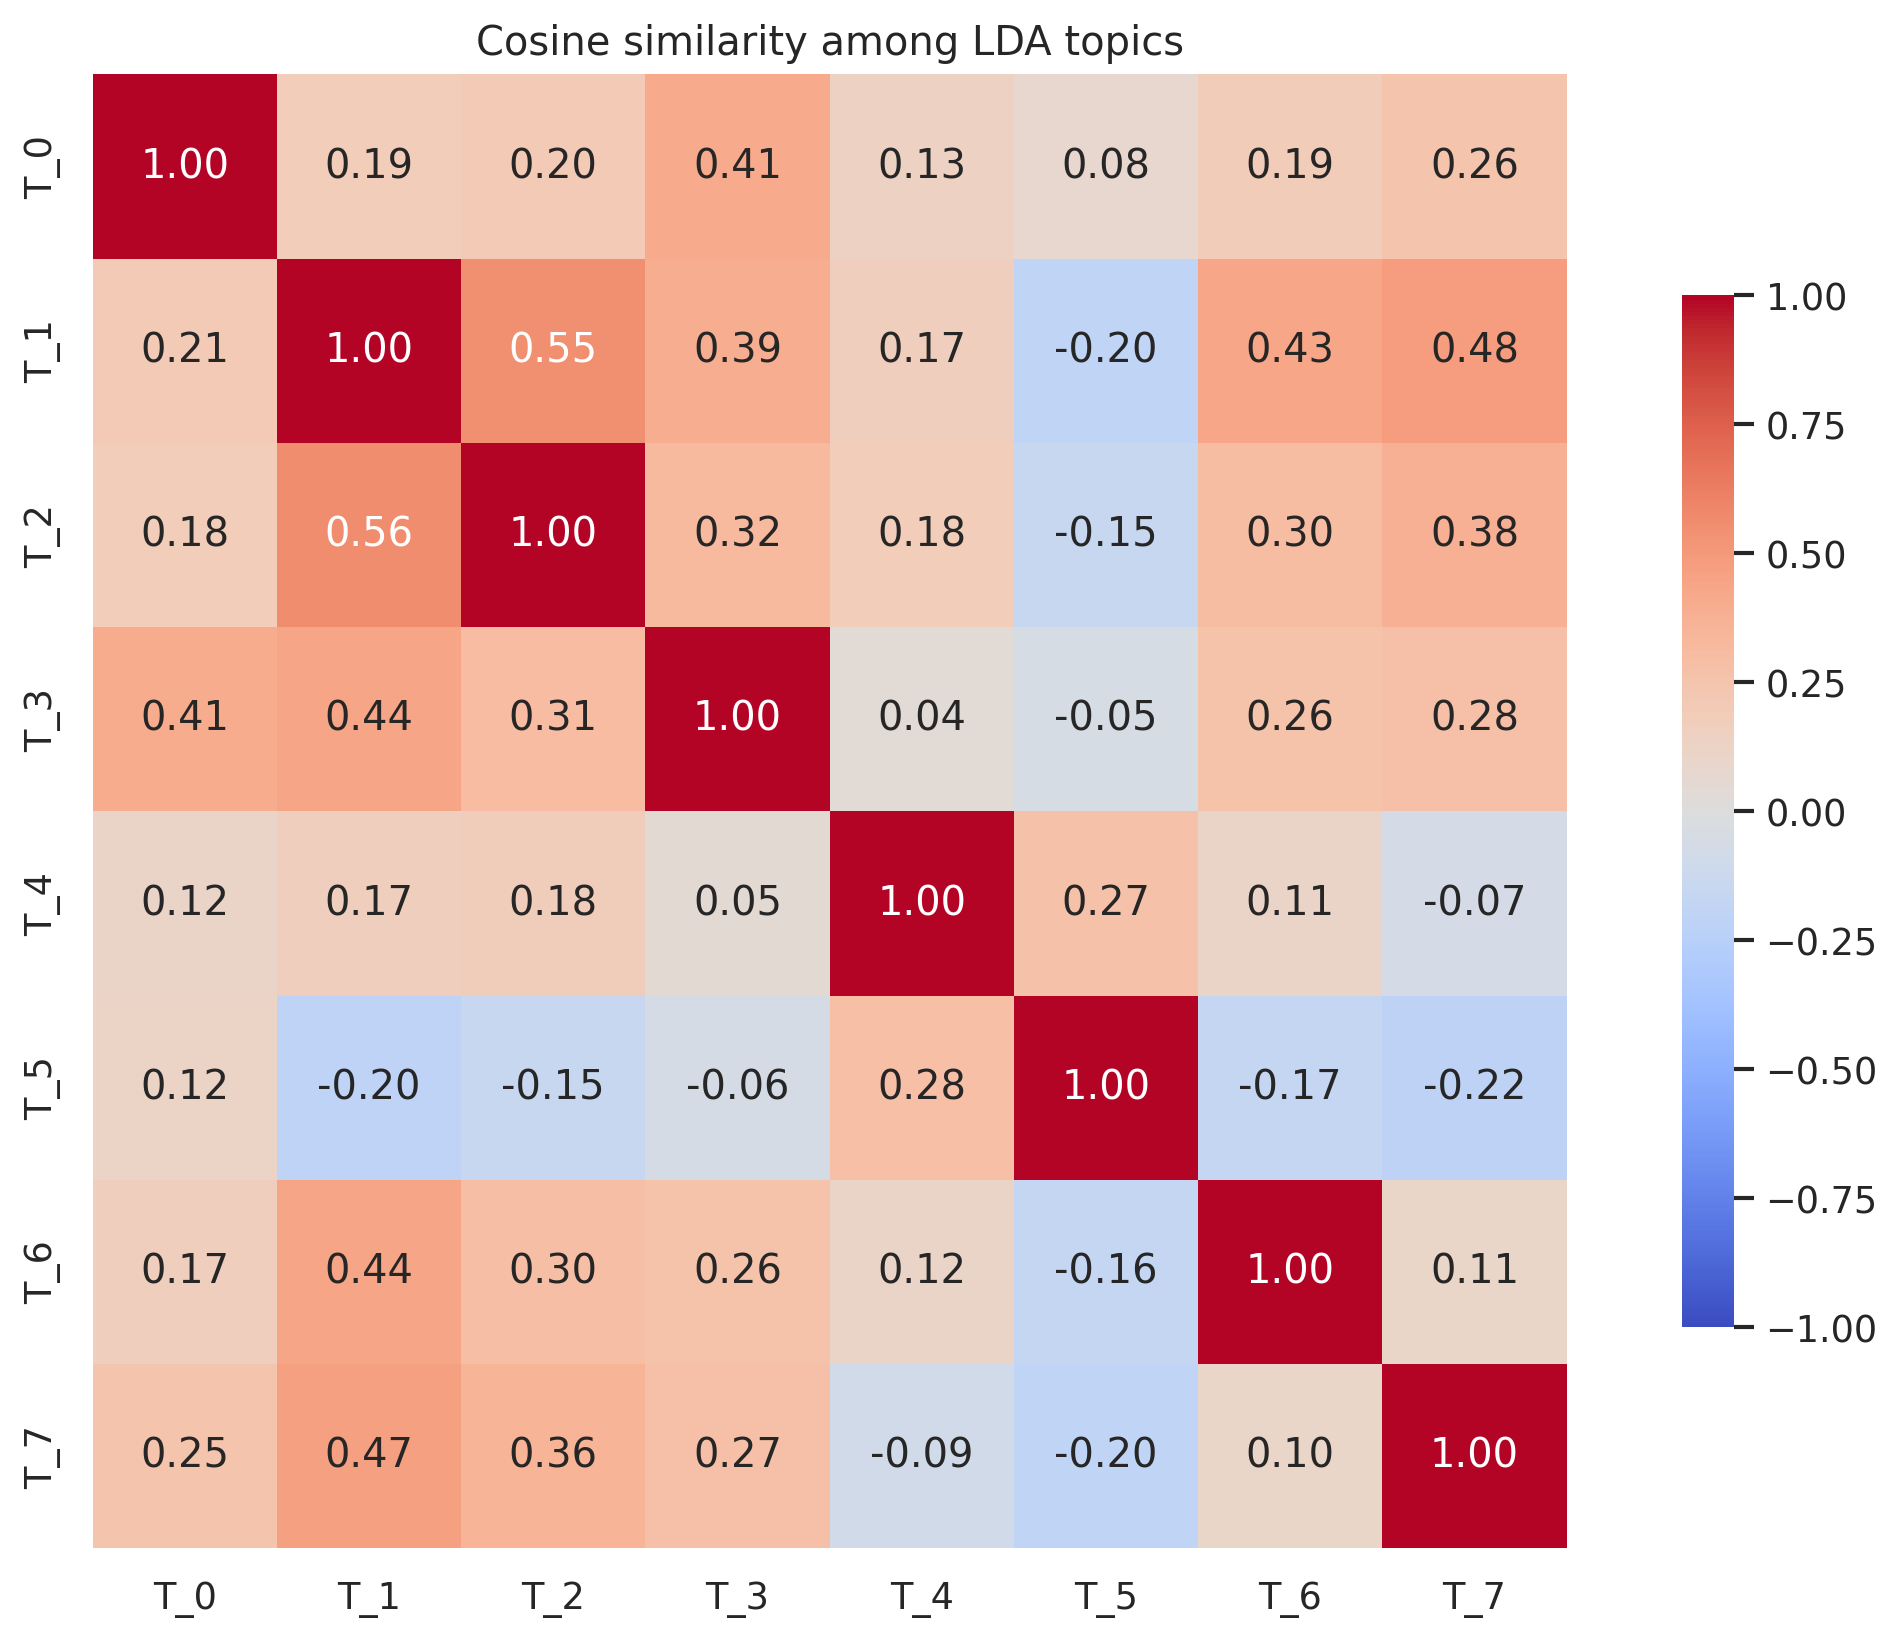

In [85]:
# Visualize similarity matrix
plt.figure(figsize=(10,7))
sns.heatmap(sim_df, vmin=-1, vmax=1, annot=True, square=True, cmap='coolwarm', fmt='.2f', cbar_kws={"shrink":.7})
plt.title("Cosine similarity among LDA topics")

plt.tight_layout()
plt.show()

It can be observed that none of the topics have similarity values near 1 (identical vectors) or -1 (opposite vectors), indicating that all the topics are unrelated between them.

## 7) Named Entity Recognition

In this section, the names of organizations mentioned in NON-SPAM emails will be extracted, using Named Entity Recognition (NER), a method to identify and classify information within unstructured text, as implemented in [Spacy](https://spacy.io/).



In [76]:
import spacy

In [77]:
# Load Spacy english model, including pre-trained word vectors and a NER component

nlp = spacy.load('en_core_web_sm')

In [78]:
# Get a DataFrame containing only NON-SPAM emails according to a source:
# - "label_num" (true NON SPAM emails)
# - "pred_nb" (Naive Bayes predictions)
# - "pred_rnn" (RNN predictions)

SOURCE = "label_num"
non_spam_df = df[df[SOURCE]==0].reset_index()

In [79]:
non_spam_df["clean_text"].head()

,clean_text
0,subject enron methanol meter follow note gave ...
1,subject hpl nom january see attached file hpln...
2,subject neon retreat ho ho ho around wonderful...
3,subject indian springs deal book teco pvr reve...
4,subject ehronline web address change message i...


In [80]:
# Process all emails text and extract all recognized organization ("ORG") names

organizations = []

for email in non_spam_df["clean_text"]:
    doc = nlp(email)
    for token in doc:
        if token.ent_type_ == "ORG":
            organizations.append(str(token))

unique_org_names = list(set(organizations))

print(f"Total number of words associated with organizations: {len(organizations)}")
print(f"Unique organization names: {len(unique_org_names)}")

Total number of words associated with organizations: 14551
Unique organization names: 1787


In [81]:
# Calculate organization frequency
org_counter = Counter(organizations)

# Get the list of most common organizations
top_orgs = org_counter.most_common(20)
orgs, freqs = zip(*top_orgs)

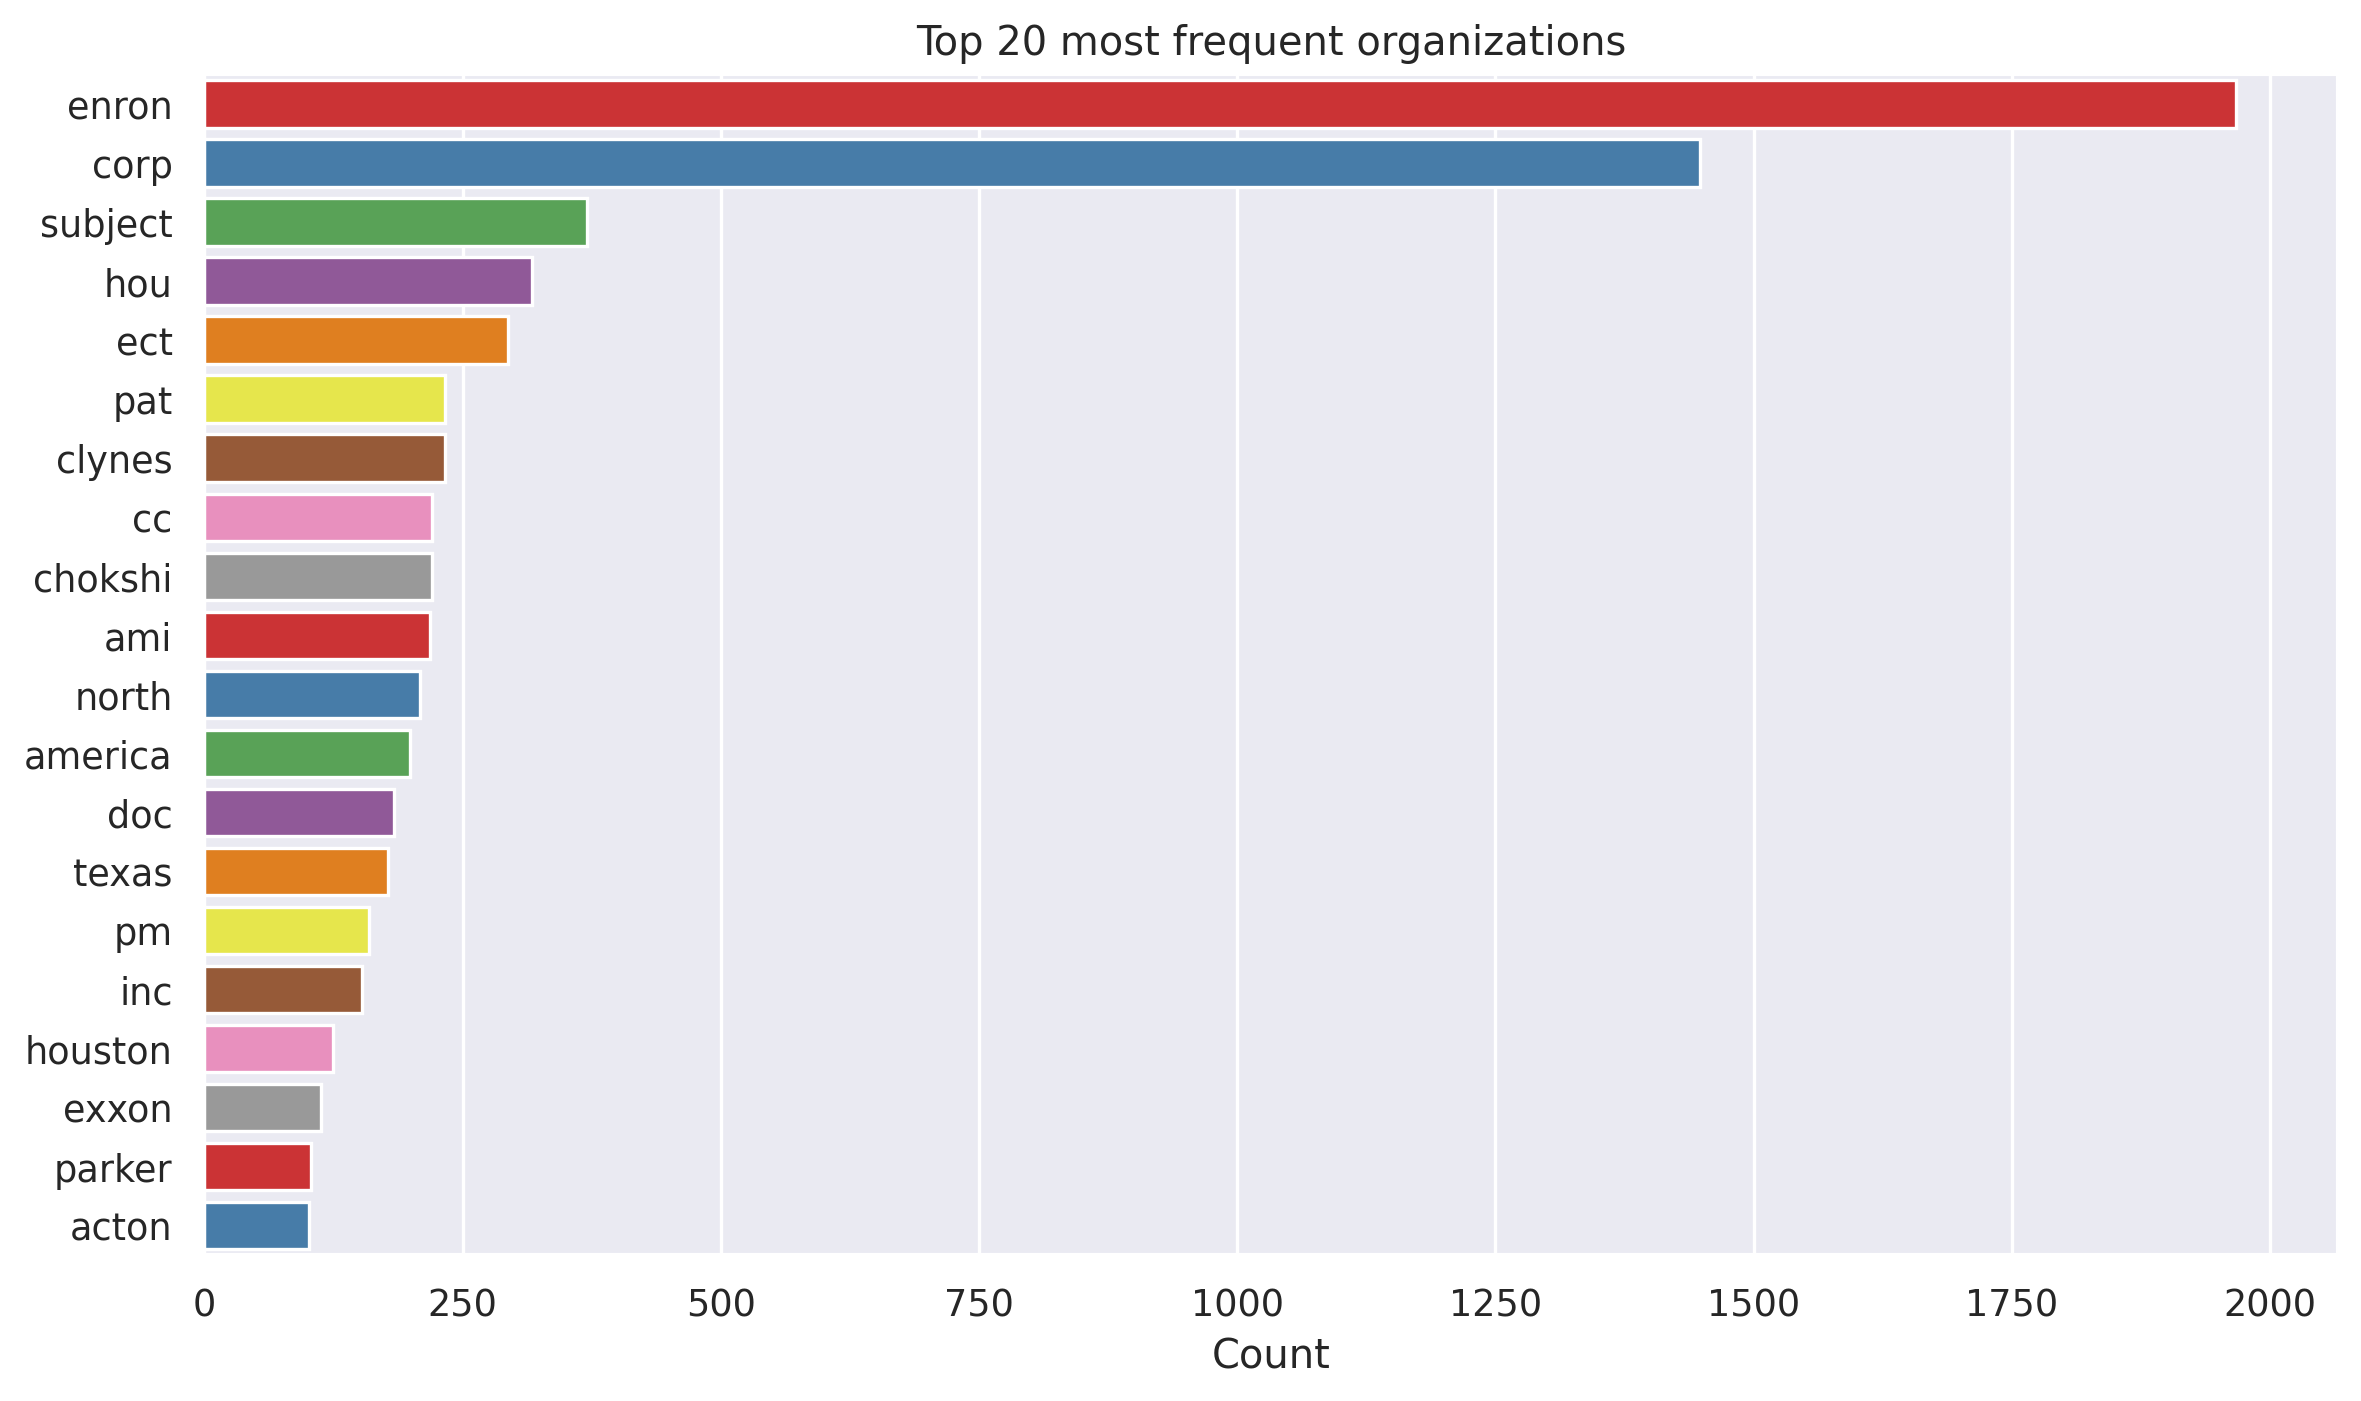

In [82]:
# Visualize the top 20 most common organizations
plt.figure(figsize=(10,6))
sns.barplot(x=freqs, y=orgs, hue=orgs, palette="Set1")
plt.xlabel("Count")
plt.title('Top 20 most frequent organizations')

plt.tight_layout()
plt.show()

## 8) Conclusions

In this project, a complete analysis of an email dataset has been performed, focusing on the identification of SPAM emails and the analysis of their content. The machine learning models trained for the SPAM/non-SPAM classification task resulted highly effective, based on all performance metrics. The method implemented to derive the main topics of SPAM emails resulted useful to evaluate the heterogeneity of SPAM contents.